<a href="https://colab.research.google.com/github/KAZMICODE/DATA_Analysis/blob/main/MEA_FINALIZED_REPORT_SLSQP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KNWOLEDGE FROM PAPER :Improvement path, the improvement potential and the dynamic evolution of
regional energy efficiency in China: Based on an improved nonradial multidirectional efficiency analysis

The paper focuses on assessing regional energy efficiency across 30 provinces in China by considering a mix of input variables (energy and non-energy), desirable outputs (economic outputs), and undesirable outputs (environmental impacts). The approach utilizes Multi- Directional efficiency Analysis to derive ideal reference points for these variables and assess the efficiency of each Decision Making Unit (DMU), in this case, the provinces.

#### FOR MY CODE
I am just considerig a random data for my code where i am takinf 20 DMU's 3 inputs , 2 desirable outputs and 1 undesirable output.
Here I am taking m for input variables , n for DMU's , s1 for desirable outputs and s2 for undesirable outputs.

**THE MAIN CONCEPT FOLLOWING**


\begin{align*}
\underset{x}{\text{min}} \quad & f(x) \\
\text{subject to} \quad & c_j(x) = 0, \quad j \in \epsilon, \\
                        & c_j(x) \geq 0, \quad j \in \tilde{I}, \\
                        & lb_i \leq x_i \leq ub_i, \quad i = 1, \ldots, N.
\end{align*}

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [ ]:
#import numpy as np

# Provided input and output data
inputs = np.array([
    [10, 12, 7], [24, 26, 5], [23, 25, 3], [12, 14, 4], [11, 13, 5],
    [12, 14, 2], [44, 46, 5], [12, 14, 7], [33, 35, 5], [22, 24, 4],
    [35, 37, 7], [21, 23, 5], [22, 24, 6], [24, 26, 8], [12, 14, 9],
    [33, 35, 2], [22, 24, 9], [12, 14, 5], [42, 44, 7], [12, 14, 4]
])

desirable_outputs = np.array([
    [34, 7], [6, 1], [24, 10], [2, 5], [29, 8],
    [7, 2], [39, 4], [6, 4], [2, 10], [7, 6],
    [1, 4], [0, 6], [10, 6], [20, 9], [5, 4],
    [7, 6], [2, 3], [32, 10], [9, 7], [5, 3]
])

# Calculate the number of rows in the inputs array
#num_rows = inputs.shape[0]

# Initialize an array of zeros with the same number of rows as inputs
#undesirable_outputs = np.zeros((num_rows, 1))

# Generate undesirable outputs
undesirable_outputs = np.zeros((inputs.shape[0], 1))  # Initialize an array for undesirable outputs

for i in range(inputs.shape[0]):
    # Simple model for undesirable output generation
    undesirable_outputs[i] = (np.sum(inputs[i,:]) / np.sum(desirable_outputs[i,:])) * 0.5  # Arbitrary formula





In [ ]:
undesirable_outputs

array([[0.35365854],
       [3.92857143],
       [0.75      ],
       [2.14285714],
       [0.39189189],
       [1.55555556],
       [1.10465116],
       [1.65      ],
       [3.04166667],
       [1.92307692],
       [7.9       ],
       [4.08333333],
       [1.625     ],
       [1.        ],
       [1.94444444],
       [2.69230769],
       [5.5       ],
       [0.36904762],
       [2.90625   ],
       [1.875     ]])

**Regarding the linear programming**

In the context of linear programming, the objective function is usually represented in the form $c^T x$, where c is a vector of coefficients and x is a vector of decision variables. Here, $d_{i0}$ is the first decision variable, and the $λ_j$ values are the other decision variables

Moreover ,
np.hstack: Stacks arrays in sequence horizontally (column-wise). This is useful when you want to add columns to an array.

np.vstack: Stacks arrays in sequence vertically (row-wise). This is useful when you want to add rows to an array.


In addition , note that we are taking transposes because
Our self.desirable_outputs and self.undesirable_outputs matrices are structured with DMUs in rows and outputs in columns.
For the constraints, we want a format where each DMU's output forms a column (not a row), so we can multiply it by the $λ$ values (which are also in a column format).

Note also that ,
for
$\sum_{j=1}^{n} \lambda_j x_{ij} \leq d_{i0}$,

To transform this into a standard format that the linear programming solver (linprog) can understand, we need to arrange it into the form $Ax \leq b$. In this standard form, A is a matrix of coefficients, x is a vector of decision variables (including $d_{i0}$  and all $λ_j$), and b is a vector representing the right-hand side of the inequalities.

In [ ]:

class MEA(object):
    def __init__(self, inputs, desirable_outputs, undesirable_outputs):
        """
        Initialize the MEA object with input data
        :param inputs: numpy array, input matrix n x m
        :param desirable_outputs: numpy array, output matrix n x r
        :param undesirable_outputs: numpy array, undesirable output matrix n x s
        """

        # Initialize input, output, and undesirable output data
        self.inputs = inputs
        self.desirable_outputs = desirable_outputs
        self.undesirable_outputs = undesirable_outputs

        # Parameters
        self.n = inputs.shape[0]  # number of entities (observations)
        self.m = inputs.shape[1]  # number of inputs (variables, features)
        self.r = desirable_outputs.shape[1]  # number of desirable outputs
        self.s = undesirable_outputs.shape[1]  # number of undesirable outputs

        # Iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.desirable_output_ = range(self.r)
        self.undesirable_output_ = range(self.s)

        # Result arrays
        self.input_efficiency = np.zeros((self.n, self.m), dtype=float)
        self.output_efficiency = np.zeros((self.n, self.r), dtype=float)
        self.undesirable_output_efficiency = np.zeros((self.n, self.s), dtype=float)
        self.comprehensive_efficiency = np.zeros(self.n, dtype=float)

        # Optimization results
        self.inputs_min = np.zeros((self.n, self.m))
        self.outputs_max = np.zeros((self.n, self.r))
        self.undesirable_outputs_min = np.zeros((self.n, self.s))
        self.beta_results = np.zeros((self.n, self.m + self.r + self.s))

    def __input_minimization(self, unit, d_target):
        # Objective function to minimize d_i0
        def objective(x):
            return x[0]

        # Constraints
        constraints = []

        # Input constraints
        for i in range(self.m):
            if i == d_target:
                input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: x[0] - np.sum(self.inputs[:, i] * x[1:])}
            else:
                input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: self.inputs[unit, i] - np.sum(self.inputs[:, i] * x[1:])}
            constraints.append(input_constraint)

        # Desirable output constraints
        for r in range(self.r):
            desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: np.sum(self.desirable_outputs[:, r] * x[1:]) - self.desirable_outputs[unit, r]}
            constraints.append(desirable_output_constraint)

        # Undesirable output constraints (equality)
        for k in range(self.s):
            undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - self.undesirable_outputs[unit, k]}
            constraints.append(undesirable_output_constraint)

        # Bounds for d_i0 and lambdas
        bounds = [(0, None)] + [(0, None) for _ in range(self.n)]

        # Solve the optimization problem
        result = minimize(objective, np.zeros(self.n + 1), method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x[0]  # Return optimized d_i0 for this unit and input
        else:
            print(f"Optimization failed for unit {unit+1} and d_target {d_target}")
            return 0

    def get_input_minimization_results(self):
        """
        Get the results of input minimization for each unit.
        """
        return self.inputs_min

    def __output_maximization(self, unit, r_target):
        # Objective function to maximize delta_r0
        def objective(x):
            return -x[0]  # Minimize negative of delta_r0

        # Constraints
        constraints = []

        # Desirable output constraints
        for r in range(self.r):
            if r == r_target:
                desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: -x[0] + np.sum(self.desirable_outputs[:, r] * x[1:])}
            else:
                desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: -self.desirable_outputs[unit, r] + np.sum(self.desirable_outputs[:, r] * x[1:])}
            constraints.append(desirable_output_constraint)

        # Input constraints
        for i in range(self.m):
            input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: -np.sum(self.inputs[:, i] * x[1:]) + self.inputs[unit, i]}
            constraints.append(input_constraint)

        # Undesirable output constraints (equality)
        for k in range(self.s):
            undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - self.undesirable_outputs[unit, k]}
            constraints.append(undesirable_output_constraint)

        # Bounds for delta_r0 and lambdas
        bounds = [(0, None) for _ in range(self.n + 1)]

        # Solve the optimization problem
        result = minimize(objective, np.zeros(self.n + 1), method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x[0]  # Return optimized delta_r0 (maximized)
        else:
            print(f"Optimization failed for unit {unit+1} and r_target {r_target}")
            return 0

    def get_output_maximization_results(self):
        """
        Get the results of output maximization for each unit.
        """
        return self.outputs_max

    def __undesirable_output_minimization(self, unit, k_target):
        # Objective function to minimize phi_k0
        def objective(x):
            return x[0]

        # Constraints
        constraints = []

        # Undesirable output constraints
        for k in range(self.s):
            if k == k_target:
                undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - x[0]}
            else:
                undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - self.undesirable_outputs[unit, k]}
            constraints.append(undesirable_output_constraint)

        # Input constraints
        for i in range(self.m):
            input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: self.inputs[unit, i] - np.sum(self.inputs[:, i] * x[1:])}
            constraints.append(input_constraint)

        # Desirable output constraints (equality)
        for r in range(self.r):
            desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: np.sum(self.desirable_outputs[:, r] * x[1:]) - self.desirable_outputs[unit, r]}
            constraints.append(desirable_output_constraint)

        # Bounds for phi_k0 and lambdas
        bounds = [(0, None)] + [(0, None) for _ in range(self.n)]

        # Solve the optimization problem
        result = minimize(objective, np.zeros(self.n + 1), method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x[0]  # Return optimized phi_k0 for this unit and input
        else:
            print(f"Optimization failed for unit {unit+1} and k_target {k_target}")
            return 0
    def get_undesirable_output_minimization_results(self):
        """
        Get the results of undesirable output minimization for each unit.
        """
        return self.undesirable_outputs_min
   # from scipy.optimize import minimize

    def __multi_objective_optimization(self, unit):
        """
        Perform multi-objective optimization for a specific unit.
        :param unit: the index of the unit (DMU)
        """
        d_star = self.inputs_min[unit]  # Optimal input values from previous optimization
        delta_star = self.outputs_max[unit]  # Optimal desirable output values from previous optimization
        phi_star = self.undesirable_outputs_min[unit]  # Optimal undesirable output values from previous optimization

        # Objective function coefficients
        c = np.concatenate((np.zeros(self.n), [-1] * (self.m + self.r + self.s)))


        # Inequality constraints for inputs
        A_ub_input = np.zeros((self.m, self.n + self.m + self.r + self.s))
        for i in range(self.m):
            A_ub_input[i, :self.n] = self.inputs[:, i]  # Coefficients for lambda_j
            A_ub_input[i, self.n + i] = self.inputs[unit, i] - d_star[i]  # Coefficient for beta_i0
        b_ub_input = self.inputs[unit]  # Right hand side

        # Inequality constraints for desirable outputs
        A_ub_desirable = np.zeros((self.r, self.n + self.m + self.r + self.s))
        for j in range(self.r):
            A_ub_desirable[j, :self.n] = -self.desirable_outputs[:, j]  # Negative coefficients for lambda_j
            A_ub_desirable[j, self.n + self.m + j] = delta_star[j] - self.desirable_outputs[unit, j]  # Coefficient for beta_r0
        b_ub_desirable = -self.desirable_outputs[unit]  # Right hand side

        # Equality constraints for undesirable outputs
        A_eq_undesirable = np.zeros((self.s, self.n + self.m + self.r + self.s))
        for k in range(self.s):
            A_eq_undesirable[k, :self.n] = self.undesirable_outputs[:, k]  # Coefficients for lambda_j
            A_eq_undesirable[k, self.n + self.m + self.r + k] = self.undesirable_outputs[unit, k] - phi_star[k]  # Coefficient for beta_k0
        b_eq_undesirable = self.undesirable_outputs[unit]  # Right hand side

        # Combine A_ub and b_ub
        A_ub = np.vstack([A_ub_input, A_ub_desirable])
        b_ub = np.hstack([b_ub_input, b_ub_desirable])

        # Bounds for variables
        x_bounds = [(0, None) for _ in range(self.n)] + [(0, 1) for _ in range(self.m + self.r + self.s)]

        # Objective function to minimize
        def objective(x):
            return np.dot(c[self.n:], x[self.n:])
            #return np.dot(c, x)
            #return np.dot(c, x[self.n:])

        # Solve the optimization problem using SLSQP method
        result = minimize(objective, np.zeros(self.n + self.m + self.r + self.s), method='SLSQP', bounds=x_bounds, constraints={'type': 'eq', 'fun': lambda x: np.dot(A_eq_undesirable, x) - b_eq_undesirable, 'jac': lambda x: A_eq_undesirable})

        if result.success:
            return result.x[self.n:]  # Extract beta values
        else:
            return None  # No solution found



    def calculate_input_efficiency(self, unit):
        """
        Calculate the MEA efficiency value of each input variable for a DMU.
        :param unit: the index of the DMU
        :return: MEA efficiency values for each input variable (numpy array).
        """
        x0 = self.inputs[unit]  # Actual input levels for the DMU
        d_i0_star = self.inputs_min[unit]  # Optimal input values from previous optimization

        # Extract beta_i0 values for the current DMU from multi-objective optimization results
        beta_i0_star = self.beta_results[unit, :self.m]

        # Calculate the MEA efficiency value for each input variable
        theta_i = (x0 - beta_i0_star * (x0 - d_i0_star)) / x0
        return theta_i

    def calculate_output_efficiency(self, unit):
        """
        Calculate the MEA efficiency value of each desirable output variable for a DMU.
        :param unit: the index of the DMU
        :return: MEA efficiency values for each desirable output variable (numpy array).
        """
        y0 = self.desirable_outputs[unit]  # Actual desirable output levels for the DMU
        delta_r0_star = self.outputs_max[unit]  # Optimal desirable output values from previous optimization

        # Extract beta_r0 values for the current DMU from multi-objective optimization results
        beta_r0_star = self.beta_results[unit, self.m:self.m+self.r]

        # Calculate the MEA efficiency value for each desirable output variable
        theta_r = y0 / (y0 + beta_r0_star * (delta_r0_star - y0))
        return theta_r

    def calculate_undesirable_output_efficiency(self, unit):
        """
        Calculate the MEA efficiency value of each undesirable output variable for a DMU.
        :param unit: the index of the DMU
        :return: MEA efficiency values for each undesirable output variable (numpy array).
        """
        c0 = self.undesirable_outputs[unit]  # Actual undesirable output levels for the DMU
        phi_k0_star = self.undesirable_outputs_min[unit]  # Optimal undesirable output values from previous optimization

        # Extract beta_k0 values for the current DMU from multi-objective optimization results
        beta_k0_star = self.beta_results[unit, self.m + self.r:self.m + self.r + self.s]

        # Calculate the MEA efficiency value for each undesirable output variable
        theta_k = (c0 - beta_k0_star * (c0 - phi_k0_star)) / c0
        return theta_k

    def calculate_comprehensive_efficiency(self):
        """
        Calculate the comprehensive MEA efficiency score for each DMU.
        :return: Comprehensive MEA efficiency scores for each DMU (numpy array).
        """
        # Initialize an array to store comprehensive efficiency for each DMU
        comprehensive_efficiency = np.zeros(self.n)

        for unit in range(self.n):
            # Extract beta_i0, beta_r0, and beta_k0 for the current DMU
            beta_i0 = self.beta_results[unit, :self.m]
            beta_r0 = self.beta_results[unit, self.m:self.m+self.r]
            beta_k0 = self.beta_results[unit, self.m+self.r:self.m+self.r+self.s]

            # Calculate numerator and denominator of the comprehensive efficiency formula
            numerator = 1 - (1 / self.m) * np.sum(beta_i0 * (self.inputs[unit] - self.inputs_min[unit]) / self.inputs[unit])
            denominator = 1 + (1 / (self.r + self.s)) * (
                np.sum(beta_r0 * (self.outputs_max[unit] - self.desirable_outputs[unit]) / self.desirable_outputs[unit]) +
                np.sum(beta_k0 * (self.undesirable_outputs[unit] - self.undesirable_outputs_min[unit]) / self.undesirable_outputs[unit])
            )
            comprehensive_efficiency[unit] = numerator / denominator

        self.comprehensive_efficiency = comprehensive_efficiency
        return comprehensive_efficiency

    def fit(self):
        # Initialize arrays to store the optimal values from the optimizations for all units
        self.beta_results = np.zeros((self.n, self.m + self.r + self.s))

        # Reset results arrays to ensure correct dimensions
        self.inputs_min = np.zeros((self.n, self.m))
        self.outputs_max = np.zeros((self.n, self.r))
        self.undesirable_outputs_min = np.zeros((self.n, self.s))
        self.input_efficiency = np.zeros((self.n, self.m), dtype=float)
        self.output_efficiency = np.zeros((self.n, self.r), dtype=float)
        self.undesirable_output_efficiency = np.zeros((self.n, self.s), dtype=float)

        # Perform MEA process for each DMU
        for unit in self.unit_:
            # Input Minimization for each input
            for i in range(self.m):
                self.inputs_min[unit, i] = self.__input_minimization(unit, i)

            # Output Maximization for each desirable output
            for r in range(self.r):
                self.outputs_max[unit, r] = self.__output_maximization(unit, r)

            # Undesirable Output Minimization for each undesirable output
            for k in range(self.s):
                self.undesirable_outputs_min[unit, k] = self.__undesirable_output_minimization(unit, k)

            # Multi-objective Optimization
            self.beta_results[unit] = self.__multi_objective_optimization(unit)

            # Calculate individual efficiencies for each unit
            self.input_efficiency[unit] = self.calculate_input_efficiency(unit)
            self.output_efficiency[unit] = self.calculate_output_efficiency(unit)
            self.undesirable_output_efficiency[unit] = self.calculate_undesirable_output_efficiency(unit)

        # Calculate comprehensive efficiency for each unit
        self.comprehensive_efficiency = self.calculate_comprehensive_efficiency()

        # Present the results
        print("Final comprehensive efficiencies for each unit:\n")
        print("---------------------------\n")
        R = pd.DataFrame([], columns=["Unit", "Comprehensive Efficiency", "Input Efficiency", "Output Efficiency", "Undesirable Output Efficiency"])
        for n in range(self.n):
            name = f"Unit {n + 1}"
            row = pd.DataFrame([[name, self.comprehensive_efficiency[n], self.input_efficiency[n].tolist(), self.output_efficiency[n].tolist(), self.undesirable_output_efficiency[n].tolist()]], columns=["Unit", "Comprehensive Efficiency", "Input Efficiency", "Output Efficiency", "Undesirable Output Efficiency"])
            R = pd.concat([R, row], ignore_index=True)
        R.sort_values(by=['Comprehensive Efficiency'], ascending=[False], inplace=True)
        print(R.to_string(index=False))
        print("---------------------------\n")



In [ ]:
mea = MEA(inputs, desirable_outputs, undesirable_outputs)

In [ ]:
mea.fit()

Optimization failed for unit 1 and d_target 2
Optimization failed for unit 1 and r_target 1


C:\Users\Hp\AppData\Local\Temp\ipykernel_10640\3658535670.py:257: RuntimeWarning: divide by zero encountered in divide
  theta_r = y0 / (y0 + beta_r0_star * (delta_r0_star - y0))


Optimization failed for unit 18 and d_target 1
Final comprehensive efficiencies for each unit:

---------------------------

   Unit  Comprehensive Efficiency                                              Input Efficiency                         Output Efficiency Undesirable Output Efficiency
 Unit 1                  1.000000                 [1.0000000000000093, 1.0000000000000286, 0.0]                  [1.000000005143455, inf]          [0.9999999999999916]
 Unit 3                  1.000000   [1.000000000000314, 1.0000000000003568, 1.0000000000000089]   [0.9999999999999982, 1.000000000000001]          [0.9999999999999942]
 Unit 7                  1.000000  [0.9999999999997052, 0.9999999959383487, 1.0000000001414322]  [1.0000000000088962, 1.0000000001572962]          [1.0000000008686858]
Unit 18                  0.891609                  [0.999999993950487, 0.0, 0.9999999898931675]   [4.112930260776599, 0.9999999999999971]          [1.0000000000000104]
 Unit 6                  0.877552  

C:\Users\Hp\AppData\Local\Temp\ipykernel_10640\3658535670.py:293: RuntimeWarning: divide by zero encountered in divide
  np.sum(beta_r0 * (self.outputs_max[unit] - self.desirable_outputs[unit]) / self.desirable_outputs[unit]) +


In [ ]:
undesirable_outputs

array([[0.35365854],
       [3.92857143],
       [0.75      ],
       [2.14285714],
       [0.39189189],
       [1.55555556],
       [1.10465116],
       [1.65      ],
       [3.04166667],
       [1.92307692],
       [7.9       ],
       [4.08333333],
       [1.625     ],
       [1.        ],
       [1.94444444],
       [2.69230769],
       [5.5       ],
       [0.36904762],
       [2.90625   ],
       [1.875     ]])

In [ ]:

class MEA(object):
    def __init__(self, inputs, desirable_outputs, undesirable_outputs):
        """
        Initialize the MEA object with input data
        :param inputs: numpy array, input matrix n x m
        :param desirable_outputs: numpy array, output matrix n x r
        :param undesirable_outputs: numpy array, undesirable output matrix n x s
        """

        # Initialize input, output, and undesirable output data
        self.inputs = inputs
        self.desirable_outputs = desirable_outputs
        self.undesirable_outputs = undesirable_outputs

        # Parameters
        self.n = inputs.shape[0]  # number of entities (observations)
        self.m = inputs.shape[1]  # number of inputs (variables, features)
        self.r = desirable_outputs.shape[1]  # number of desirable outputs
        self.s = undesirable_outputs.shape[1]  # number of undesirable outputs

        # Iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.desirable_output_ = range(self.r)
        self.undesirable_output_ = range(self.s)

        # Result arrays
        self.input_efficiency = np.zeros((self.n, self.m), dtype=float)
        self.output_efficiency = np.zeros((self.n, self.r), dtype=float)
        self.undesirable_output_efficiency = np.zeros((self.n, self.s), dtype=float)
        self.comprehensive_efficiency = np.zeros(self.n, dtype=float)

        # Optimization results
        self.inputs_min = np.zeros((self.n, self.m))
        self.outputs_max = np.zeros((self.n, self.r))
        self.undesirable_outputs_min = np.zeros((self.n, self.s))
        self.beta_results = np.zeros((self.n, self.m + self.r + self.s))

    def input_minimization(self, unit, d_target):
        # Objective function to minimize d_i0
        def objective(x):
            return x[0]

        # Constraints
        constraints = []

        # Input constraints
        for i in range(self.m):
            if i == d_target:
                input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: x[0] - np.sum(self.inputs[:, i] * x[1:])}
            else:
                input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: self.inputs[unit, i] - np.sum(self.inputs[:, i] * x[1:])}
            constraints.append(input_constraint)

        # Desirable output constraints
        for r in range(self.r):
            desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: np.sum(self.desirable_outputs[:, r] * x[1:]) - self.desirable_outputs[unit, r]}
            constraints.append(desirable_output_constraint)

        # Undesirable output constraints (equality)
        for k in range(self.s):
            undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - self.undesirable_outputs[unit, k]}
            constraints.append(undesirable_output_constraint)

        # Bounds for d_i0 and lambdas
        bounds = [(0, None)] + [(0, None) for _ in range(self.n)]

        # Solve the optimization problem
        result = minimize(objective, np.zeros(self.n + 1), method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x[0]  # Return optimized d_i0 for this unit and input
        else:
            print(f"Optimization failed for unit {unit+1} and d_target {d_target}")
            return None

    def get_input_minimization_results(self):
        """
        Get the results of input minimization for each unit.
        """
        return self.inputs_min

    def output_maximization(self, unit, r_target):
        # Objective function to maximize delta_r0
        def objective(x):
            return -x[0]  # Minimize negative of delta_r0

        # Constraints
        constraints = []

        # Desirable output constraints
        for r in range(self.r):
            if r == r_target:
                desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: -x[0] + np.sum(self.desirable_outputs[:, r] * x[1:])}
            else:
                desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: -self.desirable_outputs[unit, r] + np.sum(self.desirable_outputs[:, r] * x[1:])}
            constraints.append(desirable_output_constraint)

        # Input constraints
        for i in range(self.m):
            input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: -np.sum(self.inputs[:, i] * x[1:]) + self.inputs[unit, i]}
            constraints.append(input_constraint)

        # Undesirable output constraints (equality)
        for k in range(self.s):
            undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - self.undesirable_outputs[unit, k]}
            constraints.append(undesirable_output_constraint)

        # Bounds for delta_r0 and lambdas
        bounds = [(0, None) for _ in range(self.n + 1)]

        # Solve the optimization problem
        result = minimize(objective, np.zeros(self.n + 1), method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x[0]  # Return optimized delta_r0 (maximized)
        else:
            print(f"Optimization failed for unit {unit+1} and r_target {r_target}")
            return None

    def get_output_maximization_results(self):
        """
        Get the results of output maximization for each unit.
        """
        return self.outputs_max

    def output_minimization(self, unit, k_target):
        # Objective function to minimize phi_k0
        def objective(x):
            return x[0]

        # Constraints
        constraints = []

        # Undesirable output constraints
        for k in range(self.s):
            if k == k_target:
                undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - x[0]}
            else:
                undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[1:]) - self.undesirable_outputs[unit, k]}
            constraints.append(undesirable_output_constraint)

        # Input constraints
        for i in range(self.m):
            input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: self.inputs[unit, i] - np.sum(self.inputs[:, i] * x[1:])}
            constraints.append(input_constraint)

        # Desirable output constraints (equality)
        for r in range(self.r):
            desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, r=r: np.sum(self.desirable_outputs[:, r] * x[1:]) - self.desirable_outputs[unit, r]}
            constraints.append(desirable_output_constraint)

        # Bounds for phi_k0 and lambdas
        bounds = [(0, None)] + [(0, None) for _ in range(self.n)]

        # Solve the optimization problem
        result = minimize(objective, np.zeros(self.n + 1), method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            return result.x[0]  # Return optimized phi_k0 for this unit and input
        else:
            print(f"Optimization failed for unit {unit+1} and k_target {k_target}")
            return None

    def get_undesirable_output_minimization_results(self):
        """
        Get the results of undesirable output minimization for each unit.
        """
        return self.undesirable_outputs_min

   # from scipy.optimize import minimize

    def multi_objective_optimization(self):
        """
        Perform multi-objective optimization to compute beta values.
        """
        d_i0_results = self.inputs_min
        delta_r0_results = self.outputs_max
        phi_k0_results = self.undesirable_outputs_min

        beta_results = np.zeros((self.n, self.m + self.r + self.s))  # To store beta values for each DMU

        for unit in range(self.n):
            # Objective function coefficients
            c = np.concatenate(([0] * self.n, [-1] * (self.m + self.r + self.s)))
            def objective(x):
                return np.dot(c[self.n:], x[self.n:])

            # Constraints
            constraints = []

            # Inequality constraints for inputs
            for i in range(self.m):
                input_constraint = {'type': 'ineq', 'fun': lambda x, i=i: -np.sum(self.inputs[:, i] * x[:self.n]) + (self.inputs[unit, i]) - (x[self.n + i] * (self.inputs[unit, i] - d_i0_results[unit, i]))}
                constraints.append(input_constraint)

            # Inequality constraints for desirable outputs
            for j in range(self.r):
                desirable_output_constraint = {'type': 'ineq', 'fun': lambda x, j=j: np.sum(self.desirable_outputs[:, j] * x[:self.n]) - (self.desirable_outputs[unit, j]) - (x[self.n + self.m + j] * (delta_r0_results[unit, j] - self.desirable_outputs[unit, j]))}
                constraints.append(desirable_output_constraint)

            # Equality constraints for undesirable outputs
            for k in range(self.s):
                undesirable_output_constraint = {'type': 'eq', 'fun': lambda x, k=k: np.sum(self.undesirable_outputs[:, k] * x[:self.n]) - (self.undesirable_outputs[unit, k]) + (x[self.n + self.m + self.r + k] * (self.undesirable_outputs[unit, k] - phi_k0_results[unit, k]))}
                constraints.append(undesirable_output_constraint)

            # Lambda constraints
            #for j in range(self.n):
            #    lambda_constraint = {'type': 'ineq', 'fun': lambda x, j=j: x[j]}
            #     constraints.append(lambda_constraint)


            # Bounds for variables
            bounds = [(0, None) for _ in range(self.n)] + [(0, 1) for _ in range(self.m + self.r + self.s)]
            # Objective function to minimize



            # Solve the optimization problem
            #result = minimize(lambda x: np.sum(x[self.n:self.n+self.m+self.r+self.s]), np.zeros(self.n+self.m+self.r+self.s), method='SLSQP', bounds=bounds, constraints=constraints)
            result = minimize(objective, np.zeros(self.n+self.m+self.r+self.s), method='SLSQP', bounds=bounds, constraints=constraints)


            if result.success:
                beta_values = result.x[self.n:]  # Extract beta values
                beta_results[unit] = beta_values

        return beta_results

    def get_multi_objective_optimization(self):
        """
        Get the results of Beta values  for each unit.
        """
        return self.beta_results

    def calculate_input_efficiency(self, unit):
        """
        Calculate the MEA efficiency value of each input variable for a DMU.
        :param unit: the index of the DMU
        :return: MEA efficiency values for each input variable (numpy array).
        """
        x0 = self.inputs[unit]  # Actual input levels for the DMU
        d_i0_star = self.inputs_min[unit]  # Optimal input values from previous optimization

        # Extract beta_i0 values for the current DMU from multi-objective optimization results
        beta_i0_star = self.beta_results[unit, :self.m]

        # Calculate the MEA efficiency value for each input variable
        theta_i = (x0 - beta_i0_star * (x0 - d_i0_star)) / x0
        return theta_i

    def calculate_output_efficiency(self, unit):
        """
        Calculate the MEA efficiency value of each desirable output variable for a DMU.
        :param unit: the index of the DMU
        :return: MEA efficiency values for each desirable output variable (numpy array).
        """
        y0 = self.desirable_outputs[unit]  # Actual desirable output levels for the DMU
        delta_r0_star = self.outputs_max[unit]  # Optimal desirable output values from previous optimization

        # Extract beta_r0 values for the current DMU from multi-objective optimization results
        beta_r0_star = self.beta_results[unit, self.m:self.m+self.r]

        # Calculate the MEA efficiency value for each desirable output variable
        theta_r = np.minimum(1, y0 / (y0 + beta_r0_star * (delta_r0_star - y0)))

        #theta_r = y0 / (y0 + beta_r0_star * (delta_r0_star - y0))
        return theta_r

    def calculate_undesirable_output_efficiency(self, unit):
        """
        Calculate the MEA efficiency value of each undesirable output variable for a DMU.
        :param unit: the index of the DMU
        :return: MEA efficiency values for each undesirable output variable (numpy array).
        """
        c0 = self.undesirable_outputs[unit]  # Actual undesirable output levels for the DMU
        phi_k0_star = self.undesirable_outputs_min[unit]  # Optimal undesirable output values from previous optimization

        # Extract beta_k0 values for the current DMU from multi-objective optimization results
        beta_k0_star = self.beta_results[unit, self.m + self.r:self.m + self.r + self.s]

        # Calculate the MEA efficiency value for each undesirable output variable
        theta_k = (c0 - beta_k0_star * (c0 - phi_k0_star)) / c0
        return theta_k

    def calculate_comprehensive_efficiency(self):
        """
        Calculate the comprehensive MEA efficiency score for each DMU.
        :return: Comprehensive MEA efficiency scores for each DMU (numpy array).
        """
        # Initialize an array to store comprehensive efficiency for each DMU
        comprehensive_efficiency = np.zeros(self.n)

        for unit in range(self.n):
            # Extract beta_i0, beta_r0, and beta_k0 for the current DMU
            beta_i0 = self.beta_results[unit, :self.m]
            beta_r0 = self.beta_results[unit, self.m:self.m+self.r]
            beta_k0 = self.beta_results[unit, self.m+self.r:self.m+self.r+self.s]

            # Calculate numerator and denominator of the comprehensive efficiency formula
            numerator = 1 - (1 / self.m) * np.sum(beta_i0 * (self.inputs[unit] - self.inputs_min[unit]) / self.inputs[unit])
            denominator = 1 + (1 / (self.r + self.s)) * (
                np.sum(beta_r0 * (self.outputs_max[unit] - self.desirable_outputs[unit]) / self.desirable_outputs[unit]) +
                np.sum(beta_k0 * (self.undesirable_outputs[unit] - self.undesirable_outputs_min[unit]) / self.undesirable_outputs[unit])
            )
            comprehensive_efficiency[unit] = np.minimum(1, numerator / denominator)
            #comprehensive_efficiency[unit] = numerator / denominator

        self.comprehensive_efficiency = comprehensive_efficiency
        return comprehensive_efficiency

    def fit(self):
        # Perform MEA process for each DMU
        for unit in self.unit_:
            # Input Minimization for each input
            for i in range(self.m):
                self.inputs_min[unit, i] = self.input_minimization(unit, i)

            # Output Maximization for each desirable output
            for r in range(self.r):
                self.outputs_max[unit, r] = self.output_maximization(unit, r)

            # Undesirable Output Minimization for each undesirable output
            for k in range(self.s):
                self.undesirable_outputs_min[unit, k] = self.output_minimization(unit, k)

        # Perform multi-objective optimization
        self.beta_results = self.multi_objective_optimization()

        # Calculate individual efficiencies for each unit
        for unit in self.unit_:
            self.input_efficiency[unit] = self.calculate_input_efficiency(unit)
            self.output_efficiency[unit] = self.calculate_output_efficiency(unit)
            self.undesirable_output_efficiency[unit] = self.calculate_undesirable_output_efficiency(unit)

        # Calculate comprehensive efficiency for each unit
        self.comprehensive_efficiency = self.calculate_comprehensive_efficiency()

        # Present the results
        print("Final comprehensive efficiencies for each unit:\n")
        print("---------------------------\n")
        R = pd.DataFrame([], columns=["Unit", "Comprehensive Efficiency", "Input Efficiency", "Output Efficiency", "Undesirable Output Efficiency"])
        for n in range(self.n):
            name = f"Unit {n + 1}"
            row = pd.DataFrame([[name, self.comprehensive_efficiency[n], self.input_efficiency[n].tolist(), self.output_efficiency[n].tolist(), self.undesirable_output_efficiency[n].tolist()]], columns=["Unit", "Comprehensive Efficiency", "Input Efficiency", "Output Efficiency", "Undesirable Output Efficiency"])
            R = pd.concat([R, row], ignore_index=True)
        R.sort_values(by=['Comprehensive Efficiency'], ascending=[False], inplace=True)
        print(R.to_string(index=False))
        print("---------------------------\n")


In [ ]:
mea = MEA(inputs, desirable_outputs, undesirable_outputs)


In [ ]:
mea.fit()

Optimization failed for unit 1 and d_target 2
Optimization failed for unit 1 and r_target 1
Optimization failed for unit 18 and d_target 1
Final comprehensive efficiencies for each unit:

---------------------------

   Unit  Comprehensive Efficiency                                              Input Efficiency                         Output Efficiency Undesirable Output Efficiency
 Unit 3                  1.000000   [1.000000000000314, 1.0000000000003568, 1.0000000000000089]                 [0.9999999999999982, 1.0]          [0.9999999999999942]
 Unit 7                  1.000000  [0.9999999999997052, 0.9999999959383487, 1.0000000001414322]                                [1.0, 1.0]          [1.0000000008686858]
 Unit 5                  0.882862  [0.9547024078416156, 0.9459430390752925, 0.9520608403527803]  [0.9999999999999983, 0.9334390688807431]          [0.8401034836338744]
 Unit 6                  0.877552  [1.4657863776222324, 0.9999999882610737, 1.0000000004883702]                

C:\Users\Hp\AppData\Local\Temp\ipykernel_10640\2289363628.py:303: RuntimeWarning: divide by zero encountered in divide
  np.sum(beta_r0 * (self.outputs_max[unit] - self.desirable_outputs[unit]) / self.desirable_outputs[unit]) +


In [ ]:
comprehensive_efficiency = mea.comprehensive_efficiency
input_efficeincy = mea.input_efficiency
output_efficiency = mea.output_efficiency


In [ ]:
mea.get_undesirable_output_minimization_results()

array([[0.35365854],
       [0.06241033],
       [0.75      ],
       [0.18452381],
       [0.32376758],
       [0.07874014],
       [1.10465116],
       [0.14761905],
       [0.36904762],
       [0.22142857],
       [0.14761905],
       [0.22142857],
       [0.22142857],
       [0.33214286],
       [0.14761905],
       [0.41190476],
       [0.11071429],
       [0.36904762],
       [0.25833333],
       [0.11071429]])

In [ ]:
mea.get_input_minimization_results()


array([[10.        , 12.        ,         nan],
       [18.46898957, 19.83327381,  3.84751134],
       [23.        , 25.        ,  3.        ],
       [12.        , 14.        ,  4.        ],
       [10.49878092, 12.29725951,  4.66584333],
       [17.58943653, 13.99999984,  2.        ],
       [44.        , 45.99999981,  5.        ],
       [ 9.64360405, 11.03852504,  2.46096286],
       [27.69383692, 30.2015904 ,  4.4345952 ],
       [13.03670442, 14.73447873,  2.46221903],
       [34.99999996, 36.99999992,  7.00000028],
       [20.99999997, 23.        ,  5.0000003 ],
       [11.55122257, 13.43148045,  2.12864658],
       [12.84620061, 14.98723404,  2.72898799],
       [10.61319023, 12.11016326,  2.84218094],
       [32.99999998, 34.99999995,  2.00000001],
       [22.        , 24.        ,  9.        ],
       [11.99999993,         nan,  4.99999995],
       [16.85036169, 19.36075953,  2.31887756],
       [ 9.49465367, 10.64529444,  2.23779042]])

In [ ]:
mea.get_output_maximization_results()

array([[3.39999998e+01,            nan],
       [1.27376211e+01, 6.92679111e+00],
       [2.40000000e+01, 1.00000000e+01],
       [2.00000093e+00, 4.99999992e+00],
       [2.99218007e+01, 8.95162313e+00],
       [6.99999998e+00, 2.00000067e+00],
       [3.90000000e+01, 4.00000000e+00],
       [2.19043388e+01, 6.38926175e+00],
       [2.37435260e+01, 1.11106714e+01],
       [2.05706894e+01, 8.88828805e+00],
       [1.00000000e+00, 4.00000000e+00],
       [1.37820679e-11, 5.99999999e+00],
       [3.36685478e+01, 1.20200854e+01],
       [5.01323902e+01, 1.63367646e+01],
       [1.73647842e+01, 5.55928411e+00],
       [7.00000000e+00, 6.00000000e+00],
       [1.99999999e+00, 3.00000000e+00],
       [7.78034102e+00, 1.00000000e+01],
       [4.03245440e+01, 1.69773203e+01],
       [1.34805280e+01, 5.60416666e+00]])

In [ ]:
betas = mea.get_multi_objective_optimization()
betas

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.50022454e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00],
       [9.94123187e-01, 1.00000000e+00, 7.17315613e-01, 5.50393064e-14,
        5.99457517e-01, 9.19820680e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.99999995e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 7.88151086e-01, 1.00000000e+00,
        1.00000000e+00, 9.30112296e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 

In [ ]:
betas[0, :3]

array([0., 0., 0.])

In [ ]:
mea.input_efficiency

array([[1.        , 1.        ,        nan],
       [0.76954123, 0.76281822, 0.76950227],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [0.95470241, 0.94594304, 0.95206084],
       [1.46578638, 0.99999999, 1.        ],
       [1.        , 1.        , 1.        ],
       [0.80363367, 0.78846607, 0.48893613],
       [0.83920718, 0.86290258, 0.88691904],
       [0.59257747, 0.61393661, 0.73225645],
       [1.        , 1.        , 1.00000004],
       [1.        , 1.        , 1.00000006],
       [0.52505557, 0.56151776, 0.80216823],
       [0.53525836, 0.57643208, 0.66907295],
       [0.88443252, 0.86501166, 0.31579788],
       [1.        , 1.        , 1.00000001],
       [1.        , 1.        , 1.        ],
       [1.        ,        nan, 1.        ],
       [0.40119909, 0.44001726, 0.88740115],
       [0.79122114, 0.76037817, 0.5594476 ]])

In [ ]:
output_efficiency

array([[1.        ,        nan],
       [0.47104557, 0.14436699],
       [1.        , 1.        ],
       [0.99999953, 1.        ],
       [1.        , 0.93343907],
       [1.        , 0.99999967],
       [1.        , 1.        ],
       [0.27391833, 0.62605042],
       [0.08423349, 0.90003562],
       [0.34029001, 0.81313794],
       [1.        , 1.        ],
       [0.        , 1.        ],
       [0.32464096, 0.62331065],
       [0.58383021, 0.8407155 ],
       [0.28793908, 0.7195171 ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.22318913, 0.5427299 ],
       [0.37090535, 0.54351563]])

In [ ]:
comprehensive_efficiency

array([       nan, 0.20955242, 1.        , 0.76650098, 0.88286179,
       0.87755164, 1.        , 0.29331279, 0.1751967 , 0.32575859,
       0.75352007, 0.        , 0.29210131, 0.39509146, 0.30563284,
       0.77982706, 0.75379344,        nan, 0.21226378, 0.33118055])

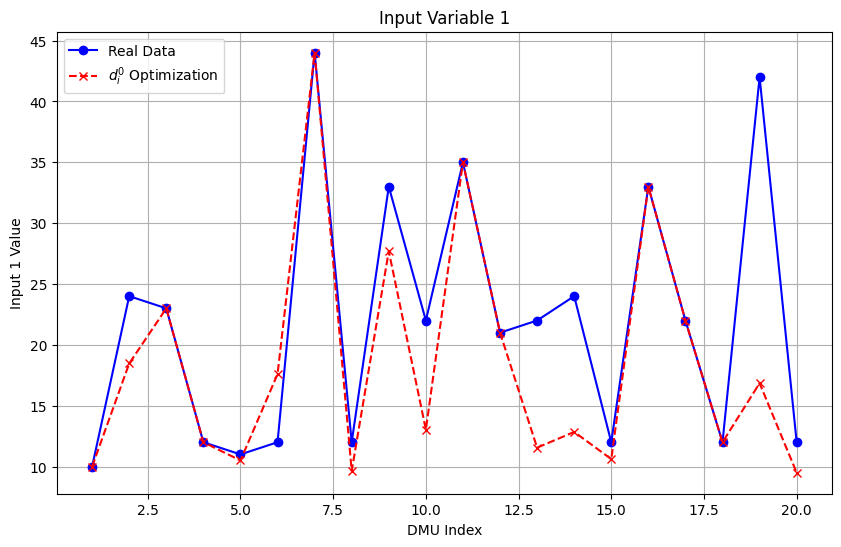

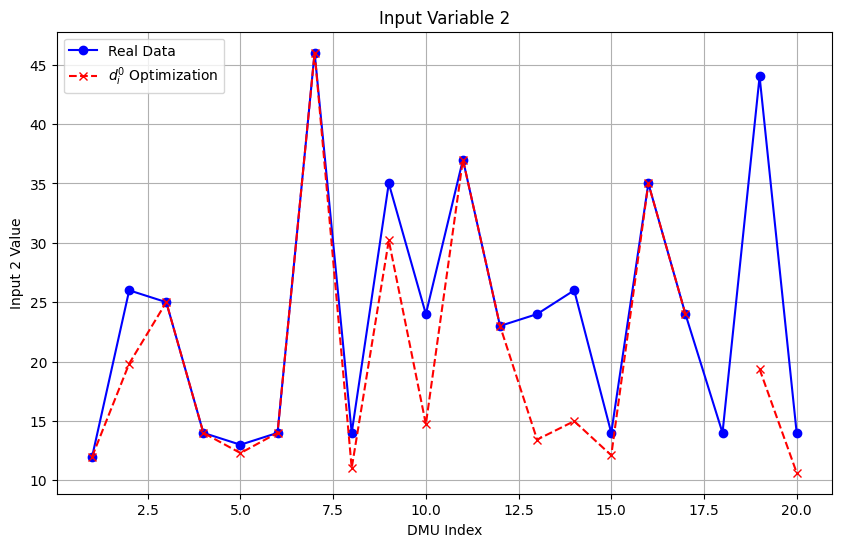

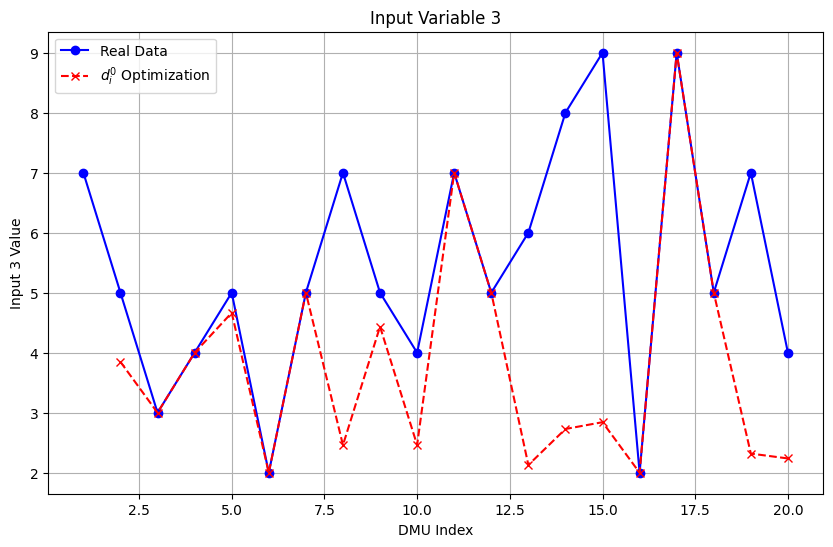

In [ ]:
# Plotting each input variable separately
d_i0_results = mea.get_input_minimization_results()
num_inputs = inputs.shape[1]

for i in range(num_inputs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(inputs) + 1), inputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    plt.plot(range(1, len(d_i0_results) + 1), d_i0_results[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    plt.title(f'Input Variable {i+1}')
    plt.xlabel('DMU Index')
    plt.ylabel(f'Input {i+1} Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
delta_r0_results = mea.get_output_maximization_results()

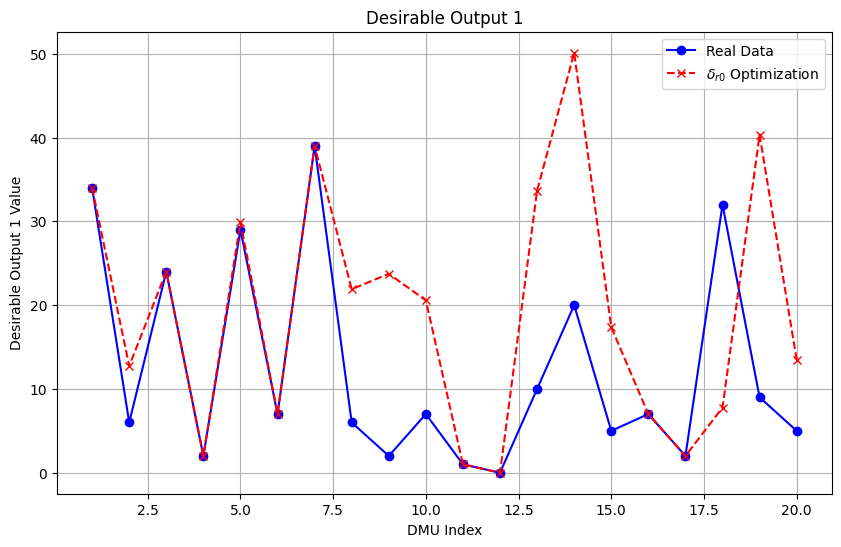

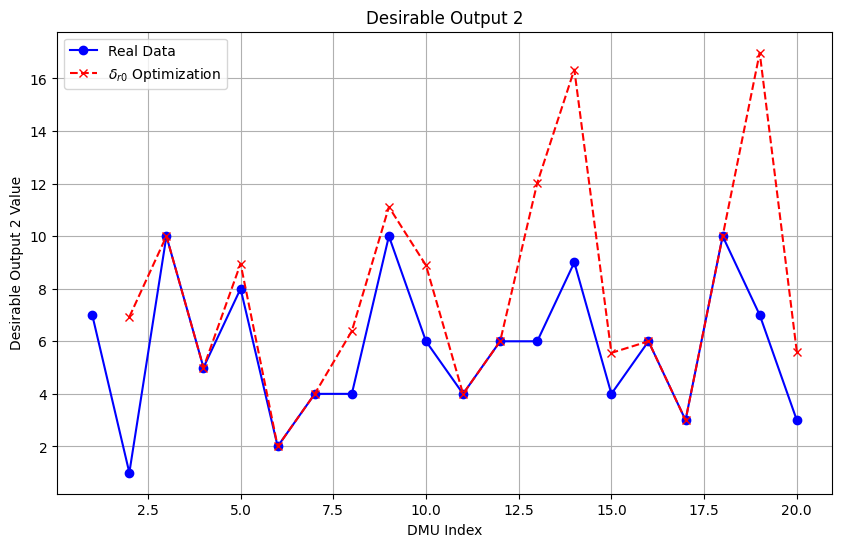

In [ ]:
# Plotting desirable_outputs for each desirable output separately
num_outputs = desirable_outputs.shape[1]

for i in range(num_outputs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(desirable_outputs) + 1), desirable_outputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    plt.plot(range(1, len(desirable_outputs) + 1), delta_r0_results[:, i], marker='x', linestyle='--', color='r', label='$\delta_{r0}$ Optimization')
    plt.title(f'Desirable Output {i+1}')
    plt.xlabel('DMU Index')
    plt.ylabel(f'Desirable Output {i+1} Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
phi_k0_results = mea.get_undesirable_output_minimization_results()

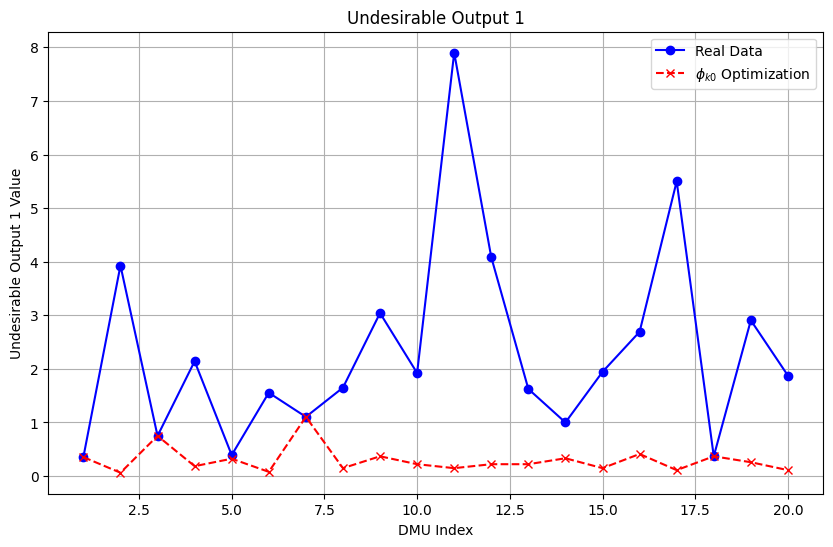

In [ ]:
# Plotting undesirable_outputs for each undesirable output separately
num_outputs = undesirable_outputs.shape[1]

for i in range(num_outputs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(undesirable_outputs) + 1), undesirable_outputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    plt.plot(range(1, len(undesirable_outputs) + 1), phi_k0_results[:, i], marker='x', linestyle='--', color='r', label='$\phi_{k0}$ Optimization')
    plt.title(f'Undesirable Output {i+1}')
    plt.xlabel('DMU Index')
    plt.ylabel(f'Undesirable Output {i+1} Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# NEXT FOR THE NORMALIZATION
## CASE 1

##### Keeping $\alpha$ = 2   for inputs and $\beta$ = 4 for the outputs , but have to scale the undesirable outputs as well so sclaing it by 4 as well


In [ ]:

#To scale the data by multiplying each value of the inputs, desirable outputs, and undesirable outputs by
#their respective scaling factors, you can use simple scalar multiplication


# Scaling factors
alpha = 2
beta = 4

# Scale inputs
scaled_inputs = inputs * alpha

# Scale desirable outputs
scaled_desirable_outputs = desirable_outputs * beta

# Scale undesirable outputs
scaled_undesirable_outputs = undesirable_outputs * beta

In [ ]:
#scaled_inputs

In [ ]:
#scaled_desirable_outputs

In [ ]:
mea = MEA(scaled_inputs, scaled_desirable_outputs, scaled_undesirable_outputs)
mea.fit()

Optimization failed for unit 1 and d_target 0
Optimization failed for unit 1 and d_target 2
Optimization failed for unit 17 and r_target 0
Final comprehensive efficiencies for each unit:

---------------------------

   Unit  Comprehensive Efficiency                                               Input Efficiency                         Output Efficiency Undesirable Output Efficiency
 Unit 3                  1.000000                   [1.000000000000003, 0.9999999999991362, 1.0]                                [1.0, 1.0]           [0.999999999999999]
 Unit 7                  1.000000      [0.999999985661811, 0.99999996034232, 1.0000000017362638]                                [1.0, 1.0]          [1.0000000001153926]
Unit 18                  1.000000   [1.0000000000000226, 0.9999999999999819, 12.350854493633275]                                [1.0, 1.0]          [1.0000000000000238]
 Unit 6                  0.906192   [0.9999999997672543, 0.9999999982484393, 0.9999999987846561]           

C:\Users\Hp\AppData\Local\Temp\ipykernel_10640\2289363628.py:303: RuntimeWarning: divide by zero encountered in divide
  np.sum(beta_r0 * (self.outputs_max[unit] - self.desirable_outputs[unit]) / self.desirable_outputs[unit]) +


In [ ]:
d_i0_results_scaled = mea.get_input_minimization_results()
delta_r0_results_scaled = mea.get_output_maximization_results()
phi_k0_results_scaled = mea.get_undesirable_output_minimization_results()

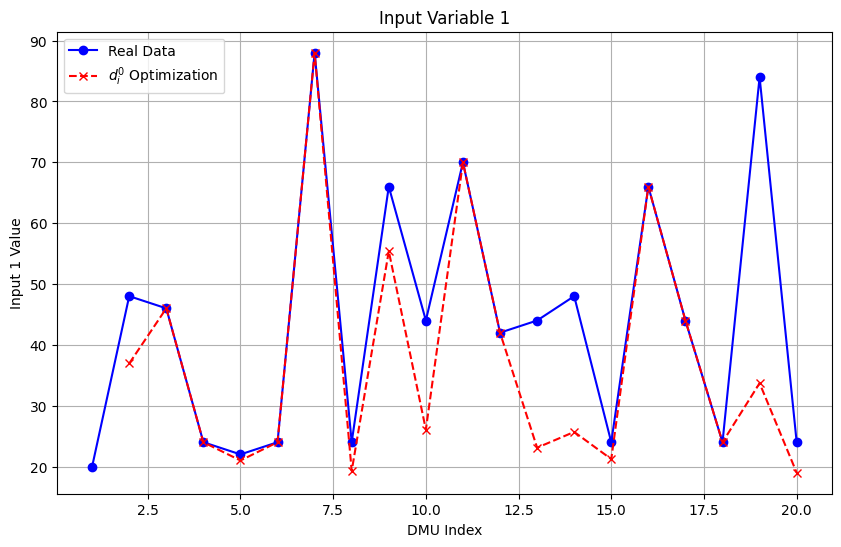

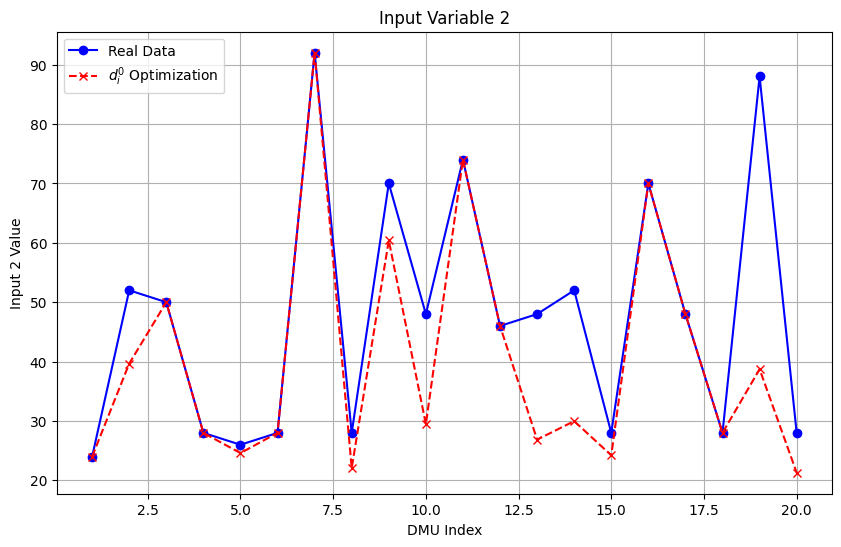

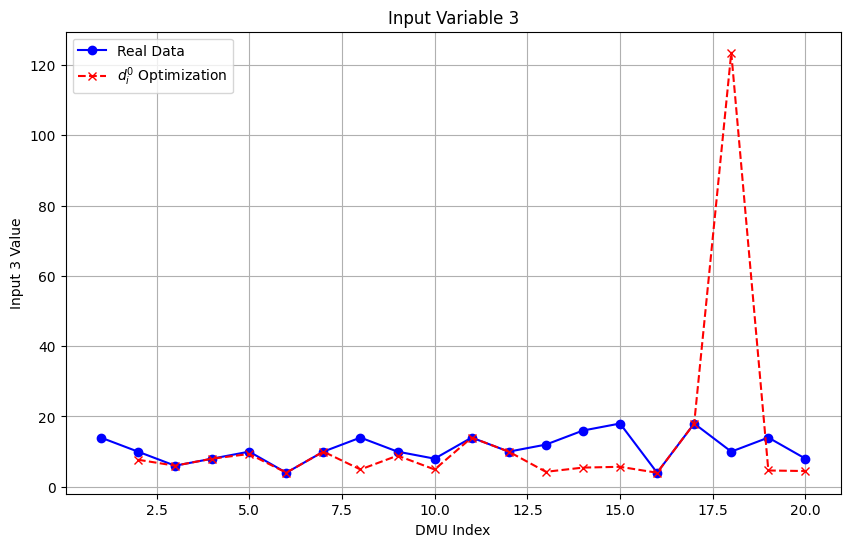

In [ ]:
# Plotting each input variable separately
num_inputs = scaled_inputs.shape[1]

for i in range(num_inputs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(scaled_inputs) + 1), scaled_inputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    plt.plot(range(1, len(d_i0_results_scaled) + 1), d_i0_results_scaled[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    plt.title(f'Input Variable {i+1}')
    plt.xlabel('DMU Index')
    plt.ylabel(f'Input {i+1} Value')
    plt.legend()
    plt.grid(True)
    plt.show()

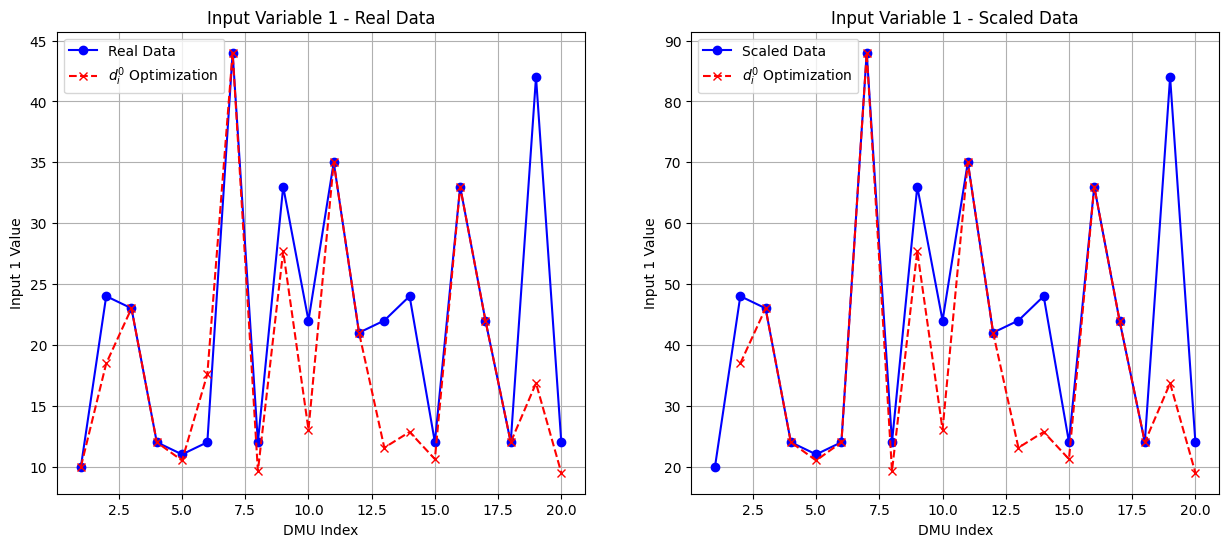

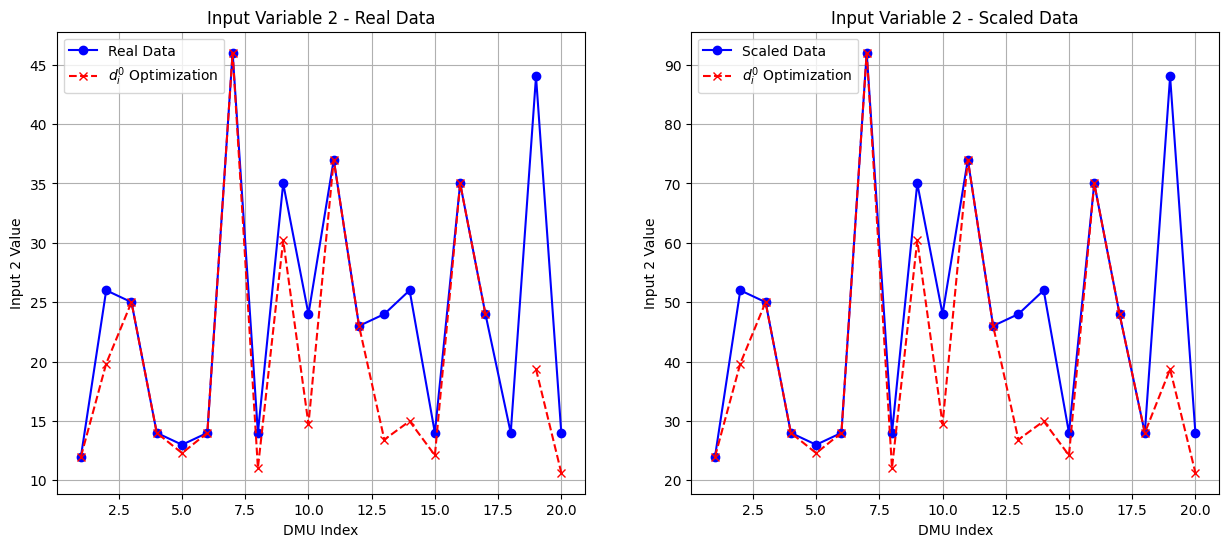

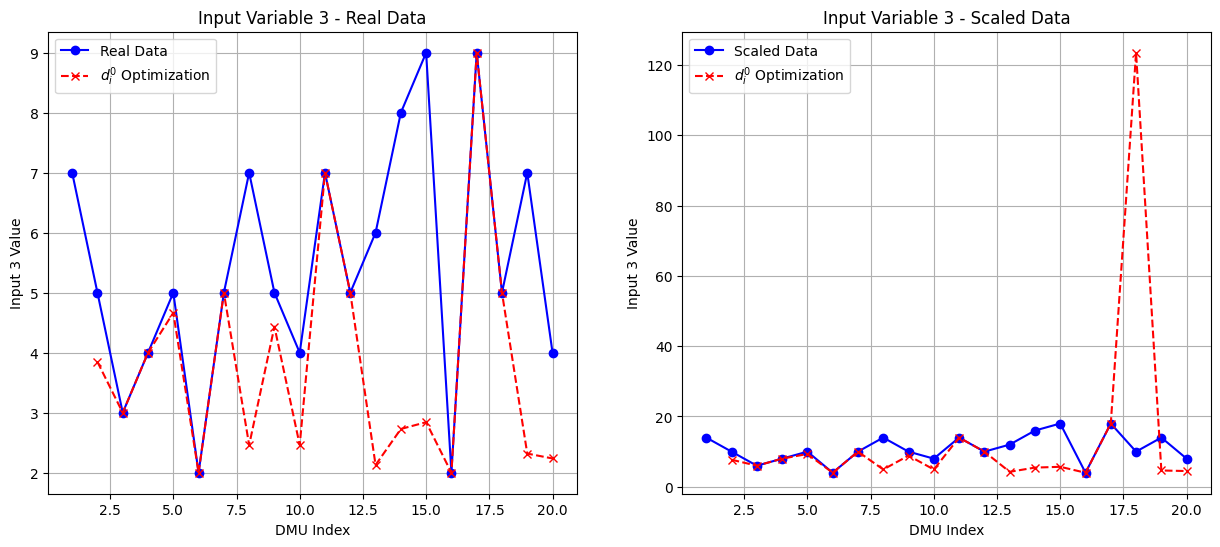

In [ ]:
# Plotting real data and scaled data for inputs
num_inputs = inputs.shape[1]

for i in range(num_inputs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Create subplots with 1 row and 2 columns
    axs[0].plot(range(1, len(inputs) + 1), inputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    axs[0].plot(range(1, len(d_i0_results) + 1), d_i0_results[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[0].set_title(f'Input Variable {i+1} - Real Data')
    axs[0].set_xlabel('DMU Index')
    axs[0].set_ylabel(f'Input {i+1} Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(1, len(scaled_inputs) + 1), scaled_inputs[:, i], marker='o', linestyle='-', color='b', label='Scaled Data')
    axs[1].plot(range(1, len(d_i0_results_scaled) + 1), d_i0_results_scaled[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[1].set_title(f'Input Variable {i+1} - Scaled Data')
    axs[1].set_xlabel('DMU Index')
    axs[1].set_ylabel(f'Input {i+1} Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()


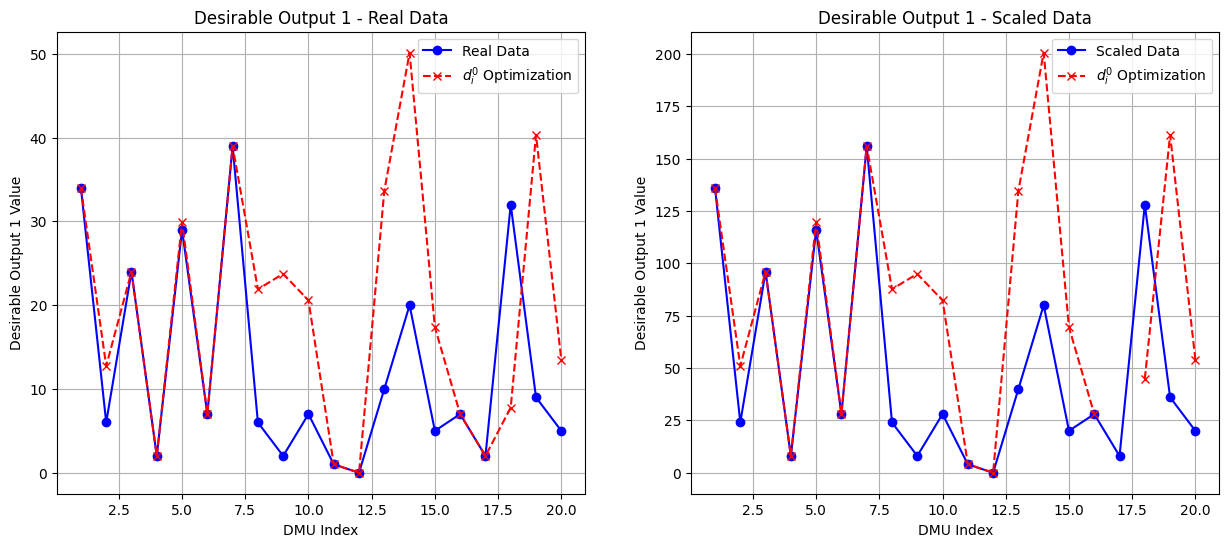

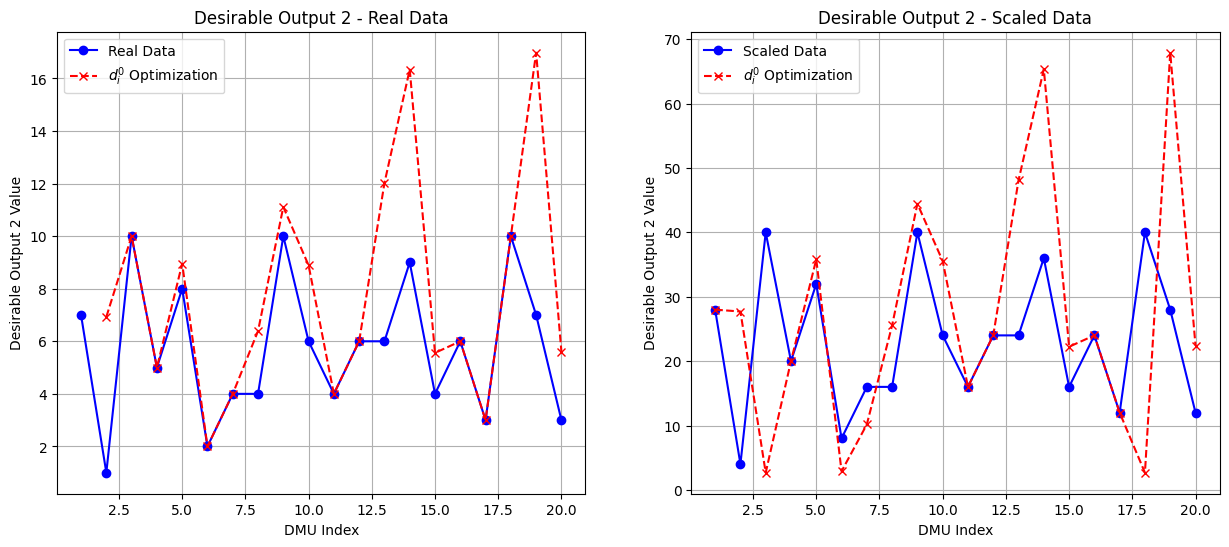

In [ ]:
# Plotting real data and scaled data for outputs

num_outputs = desirable_outputs.shape[1]
for i in range(num_outputs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Create subplots with 1 row and 2 columns
    axs[0].plot(range(1, len(desirable_outputs) + 1), desirable_outputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    axs[0].plot(range(1, len(delta_r0_results) + 1), delta_r0_results[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[0].set_title(f'Desirable Output {i+1} - Real Data')
    axs[0].set_xlabel('DMU Index')
    axs[0].set_ylabel(f'Desirable Output {i+1} Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(1, len(scaled_desirable_outputs) + 1), scaled_desirable_outputs[:, i], marker='o', linestyle='-', color='b', label='Scaled Data')
    axs[1].plot(range(1, len(delta_r0_results_scaled) + 1), delta_r0_results_scaled[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[1].set_title(f'Desirable Output {i+1} - Scaled Data')
    axs[1].set_xlabel('DMU Index')
    axs[1].set_ylabel(f'Desirable Output {i+1} Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()


## CASE 2
#### Providing different values of $\alpha$ and $\beta$

In [ ]:
# Define separate scaling factors for inputs, desirable outputs, and undesirable outputs
alpha_values = [2, 3, 4]  # Scaling factors for inputs
beta_values = [4, 5]      # Scaling factors for desirable outputs
gamma_values = [2]        # Scaling factors for undesirable outputs

# Initialize scaled data arrays
scaled_inputs_r = np.zeros_like(inputs)
scaled_desirable_outputs_r = np.zeros_like(desirable_outputs)
scaled_undesirable_outputs_r = np.zeros_like(undesirable_outputs)

# Scale inputs
for i in range(inputs.shape[1]):
    scaled_inputs_r[:, i] = inputs[:, i] * alpha_values[i]

# Scale desirable outputs
for i in range(desirable_outputs.shape[1]):
    scaled_desirable_outputs_r[:, i] = desirable_outputs[:, i] * beta_values[i]

# Scale undesirable outputs
for i in range(undesirable_outputs.shape[1]):
    scaled_undesirable_outputs_r[:, i] = undesirable_outputs[:, i] * gamma_values[i]


In [ ]:
mea = MEA(scaled_inputs_r, scaled_desirable_outputs_r, scaled_undesirable_outputs_r)
mea.fit()

Optimization failed for unit 1 and d_target 0
Final comprehensive efficiencies for each unit:

---------------------------

   Unit  Comprehensive Efficiency                                             Input Efficiency                         Output Efficiency Undesirable Output Efficiency
 Unit 7                  1.000000  [0.9999999999748954, 1.0000000000009859, 1.000000001736317]                 [1.0, 0.9999999999958312]          [0.9999999991098826]
Unit 18                  1.000000  [0.9999999999907657, 560.8403734179757, 0.9999999999999597]                 [0.9999999999998996, 1.0]                         [1.0]
 Unit 3                  1.000000  [0.999999999999483, 1.0000000000018754, 0.9999999999998742]                                [1.0, 1.0]           [1.000000000000019]
Unit 11                  0.963148                [1.0, 0.9999999996136051, 1.0000000000000016]                                [1.0, 1.0]         [0.01868595539103065]
Unit 17                  0.950074  [0.999

C:\Users\Hp\AppData\Local\Temp\ipykernel_10640\2289363628.py:303: RuntimeWarning: divide by zero encountered in divide
  np.sum(beta_r0 * (self.outputs_max[unit] - self.desirable_outputs[unit]) / self.desirable_outputs[unit]) +


In [ ]:
comprehensive_efficiency_r = mea.comprehensive_efficiency
input_efficeincy_r = mea.input_efficiency

In [ ]:
d_i0_results_scaled_r = mea.get_input_minimization_results()
delta_r0_results_scaled_r = mea.get_output_maximization_results()
phi_k0_results_scaled_r = mea.get_undesirable_output_minimization_results()

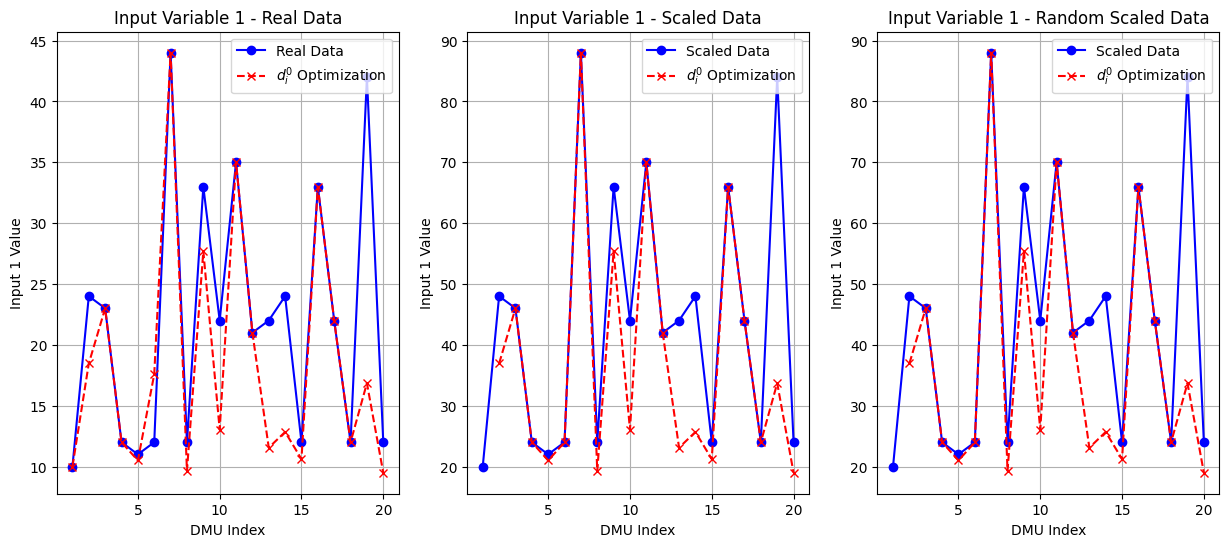

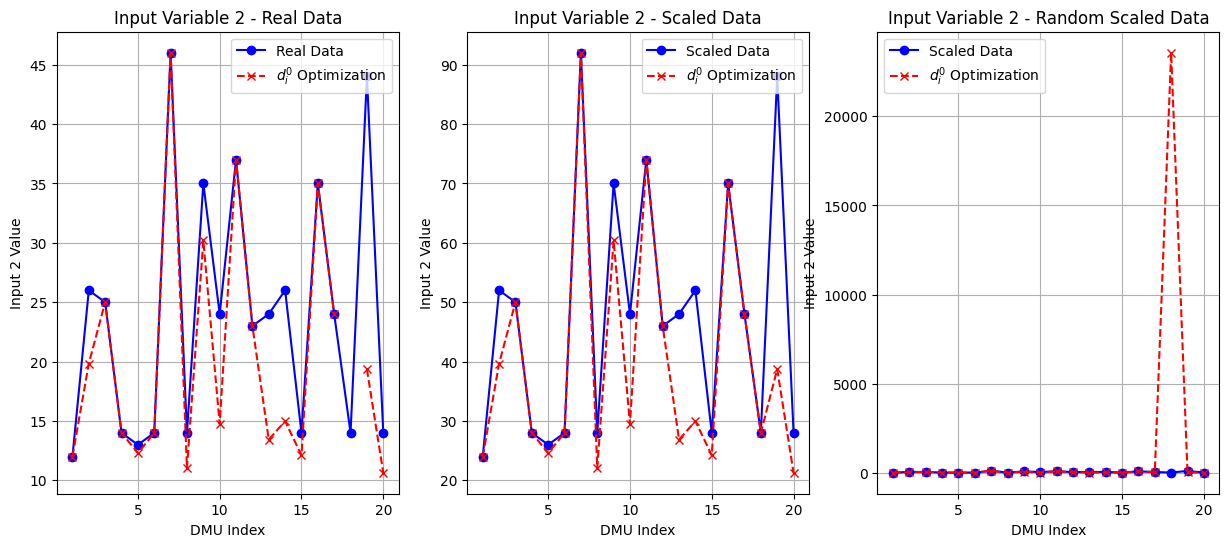

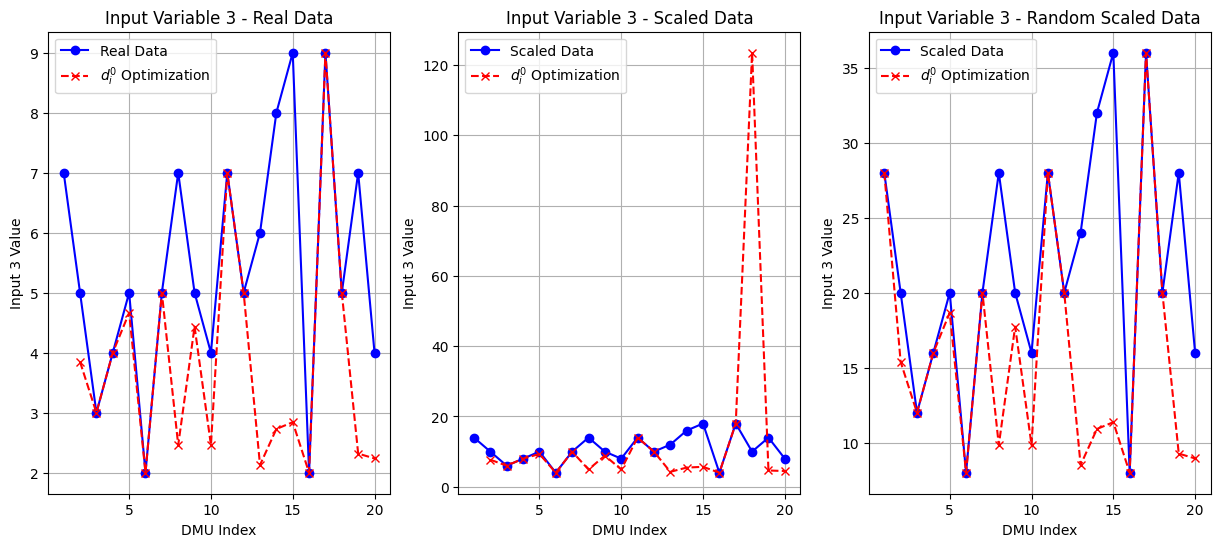

In [ ]:
# Plotting real data and scaled data for inputs
num_inputs = inputs.shape[1]

for i in range(num_inputs):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))  # Create subplots with 1 row and 2 columns
    axs[0].plot(range(1, len(inputs) + 1), inputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    axs[0].plot(range(1, len(d_i0_results) + 1), d_i0_results[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[0].set_title(f'Input Variable {i+1} - Real Data')
    axs[0].set_xlabel('DMU Index')
    axs[0].set_ylabel(f'Input {i+1} Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(1, len(scaled_inputs) + 1), scaled_inputs[:, i], marker='o', linestyle='-', color='b', label='Scaled Data')
    axs[1].plot(range(1, len(d_i0_results_scaled) + 1), d_i0_results_scaled[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[1].set_title(f'Input Variable {i+1} - Scaled Data')
    axs[1].set_xlabel('DMU Index')
    axs[1].set_ylabel(f'Input {i+1} Value')
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(range(1, len(scaled_inputs_r) + 1), scaled_inputs_r[:, i], marker='o', linestyle='-', color='b', label='Scaled Data')
    axs[2].plot(range(1, len(d_i0_results_scaled_r) + 1), d_i0_results_scaled_r[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[2].set_title(f'Input Variable {i+1} - Random Scaled Data')
    axs[2].set_xlabel('DMU Index')
    axs[2].set_ylabel(f'Input {i+1} Value')
    axs[2].legend()
    axs[2].grid(True)


    plt.show()


##### Considering the case $\alpha_1x_1 + c_1 ,  \alpha_2x_2 + c_2 , \alpha_3x_3 + c_3 , \beta_1y_1 + c_4 , \beta_2y_2 + c_5$ $,  \gamma_1c_1 + c_6 $

In [ ]:
# Define separate scaling factors for inputs, desirable outputs, and undesirable outputs
alpha_values = [2, 3, 4]  # Scaling factors for inputs
beta_values = [4, 5]      # Scaling factors for desirable outputs
gamma_values = [3]        # Scaling factors for undesirable outputs
c_values = [10, 20, 30, 40, 50, 60]  # Random constants for scaled values

# Initialize scaled data arrays
scaled_inputs_r_con = np.zeros_like(inputs)
scaled_desirable_outputs_r_con = np.zeros_like(desirable_outputs)
scaled_undesirable_outputs_r_con = np.zeros_like(undesirable_outputs)

# Scale inputs
for i in range(inputs.shape[1]):
    scaled_inputs_r_con[:, i] = inputs[:, i] * alpha_values[i] + c_values[i]

# Scale desirable outputs
for i in range(desirable_outputs.shape[1]):
    scaled_desirable_outputs_r_con[:, i] = desirable_outputs[:, i] * beta_values[i] + c_values[i + len(alpha_values)]

# Scale undesirable outputs
for i in range(undesirable_outputs.shape[1]):
    scaled_undesirable_outputs_r_con[:, i] = undesirable_outputs[:, i] * gamma_values[i] + c_values[i + len(alpha_values) + len(beta_values)]


In [ ]:
mea = MEA(scaled_inputs_r_con, scaled_desirable_outputs_r_con, scaled_undesirable_outputs_r_con)
mea.fit()

Optimization failed for unit 16 and r_target 0
Optimization failed for unit 18 and d_target 1
Optimization failed for unit 18 and d_target 2
Final comprehensive efficiencies for each unit:

---------------------------

   Unit  Comprehensive Efficiency                                             Input Efficiency                         Output Efficiency Undesirable Output Efficiency
 Unit 1                  1.000000 [1.0000000000000244, 0.9999999999999504, 0.9999999999999523]                                [1.0, 1.0]          [1.0000000000009472]
 Unit 7                  1.000000 [0.9999999999879358, 1.0000000000000013, 1.0000000007088259]                                [1.0, 1.0]          [0.9999999999987332]
 Unit 3                  1.000000 [1.0000000000004228, 1.0000000000038403, 0.9999999999998168]                                [1.0, 1.0]          [1.0000000000009142]
 Unit 5                  1.000000  [0.9999999980504651, 0.999999997841592, 0.9999999965566204]                 [1

In [ ]:
comprehensive_efficiency_r_con = mea.comprehensive_efficiency
input_efficeincy_r_con = mea.input_efficiency

In [ ]:
comprehensive_efficiency

array([       nan, 0.20955242, 1.        , 0.76650098, 0.88286179,
       0.87755164, 1.        , 0.29331279, 0.1751967 , 0.32575859,
       0.75352007, 0.        , 0.29210131, 0.39509146, 0.30563284,
       0.77982706, 0.75379344,        nan, 0.21226378, 0.33118055])

In [ ]:
comprehensive_efficiency_r

array([       nan, 0.20955242, 1.        , 0.76650106, 0.88286179,
       0.75961264, 1.        , 0.29331279, 0.1751967 , 0.32575859,
       0.96314763, 0.        , 0.29210131, 0.39509146, 0.30563284,
       0.92592443, 0.95007426, 1.        , 0.21226378, 0.33118054])

In [ ]:
comprehensive_efficiency_r_con

array([1.        , 0.43204383, 1.        , 0.90632232, 1.        ,
       0.8738645 , 1.        , 0.5701986 , 0.40345049, 0.52016117,
       0.31012336, 0.39139003, 0.50899887, 0.57263732, 0.51478415,
              nan, 0.37242093,        nan, 0.36903723, 0.6948365 ])

In [ ]:
d_i0_results_scaled_r_con = mea.get_input_minimization_results()
delta_r0_results_scaled_r_con = mea.get_output_maximization_results()
phi_k0_results_scaled_r_con = mea.get_undesirable_output_minimization_results()

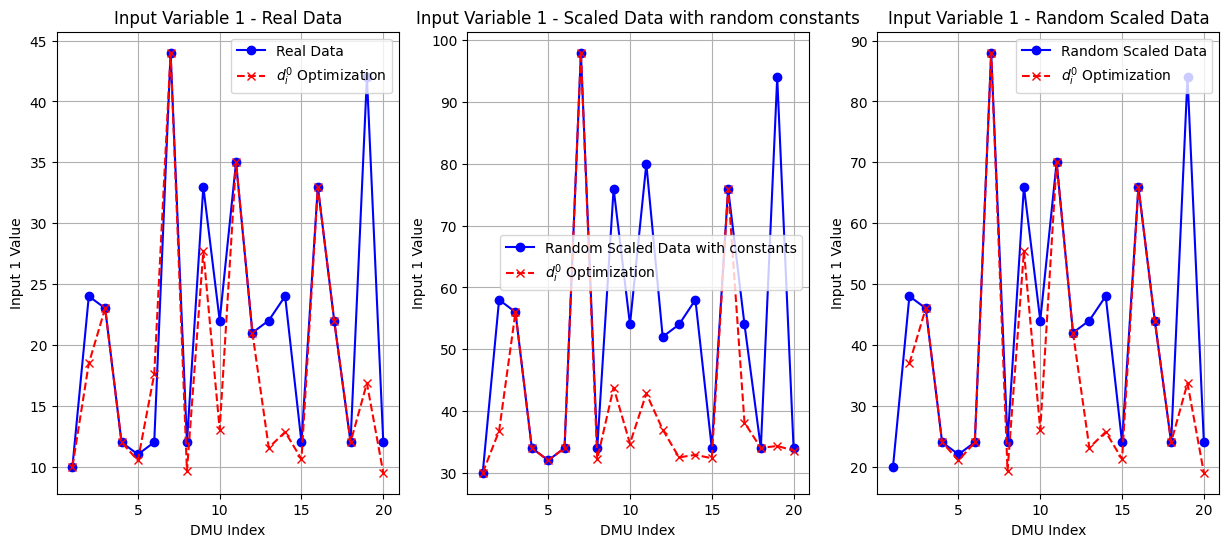

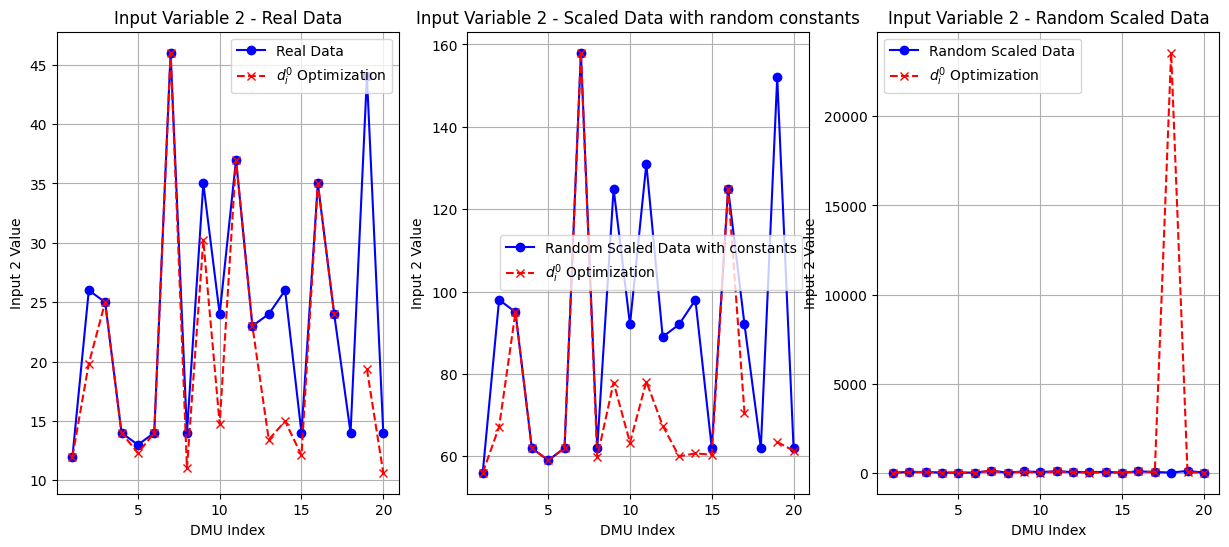

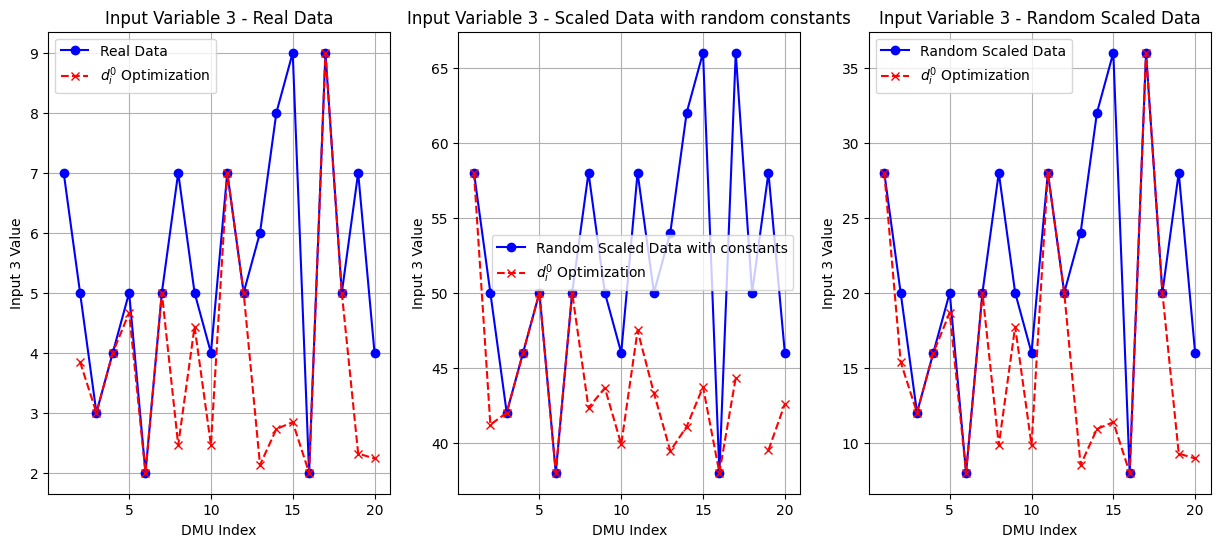

In [ ]:
# Plotting real data and scaled data for inputs
num_inputs = inputs.shape[1]

for i in range(num_inputs):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))  # Create subplots with 1 row and 2 columns
    axs[0].plot(range(1, len(inputs) + 1), inputs[:, i], marker='o', linestyle='-', color='b', label='Real Data')
    axs[0].plot(range(1, len(d_i0_results) + 1), d_i0_results[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[0].set_title(f'Input Variable {i+1} - Real Data')
    axs[0].set_xlabel('DMU Index')
    axs[0].set_ylabel(f'Input {i+1} Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(1, len(scaled_inputs_r_con) + 1), scaled_inputs_r_con[:, i], marker='o', linestyle='-', color='b', label='Random Scaled Data with constants')
    axs[1].plot(range(1, len(d_i0_results_scaled_r_con) + 1), d_i0_results_scaled_r_con[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[1].set_title(f'Input Variable {i+1} - Scaled Data with random constants')
    axs[1].set_xlabel('DMU Index')
    axs[1].set_ylabel(f'Input {i+1} Value')
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(range(1, len(scaled_inputs_r) + 1), scaled_inputs_r[:, i], marker='o', linestyle='-', color='b', label='Random Scaled Data')
    axs[2].plot(range(1, len(d_i0_results_scaled_r) + 1), d_i0_results_scaled_r[:, i], marker='x', linestyle='--', color='r', label='$d_i^0$ Optimization')
    axs[2].set_title(f'Input Variable {i+1} - Random Scaled Data')
    axs[2].set_xlabel('DMU Index')
    axs[2].set_ylabel(f'Input {i+1} Value')
    axs[2].legend()
    axs[2].grid(True)


    plt.show()


In [ ]:
comprehensive_efficiency

array([       nan, 0.20955242, 1.        , 0.76650098, 0.88286179,
       0.87755164, 1.        , 0.29331279, 0.1751967 , 0.32575859,
       0.75352007, 0.        , 0.29210131, 0.39509146, 0.30563284,
       0.77982706, 0.75379344,        nan, 0.21226378, 0.33118055])

In [ ]:
comprehensive_efficiency_r_con

array([1.        , 0.43204383, 1.        , 0.90632232, 1.        ,
       0.8738645 , 1.        , 0.5701986 , 0.40345049, 0.52016117,
       0.31012336, 0.39139003, 0.50899887, 0.57263732, 0.51478415,
              nan, 0.37242093,        nan, 0.36903723, 0.6948365 ])

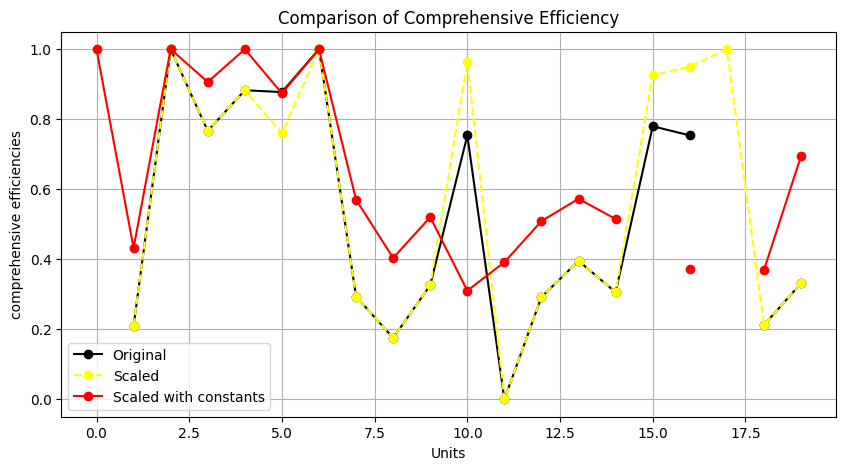

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting input efficiency values for the original data
plt.plot(np.arange(len(comprehensive_efficiency)), comprehensive_efficiency, marker='o', linestyle='-', color='black', label='Original')
# Plotting input efficiency values for the scaled data with constants
plt.plot(np.arange(len(comprehensive_efficiency_r)), comprehensive_efficiency_r, marker='o', linestyle='--', color='yellow', label='Scaled')

# Plotting input efficiency values for the scaled data with constants
plt.plot(np.arange(len(comprehensive_efficiency_r_con)), comprehensive_efficiency_r_con, marker='o', linestyle='-', color='red', label='Scaled with constants')

plt.xlabel('Units')
plt.ylabel('comprehensive efficiencies')
plt.title('Comparison of Comprehensive Efficiency')
plt.legend()
plt.grid(True)
plt.show()

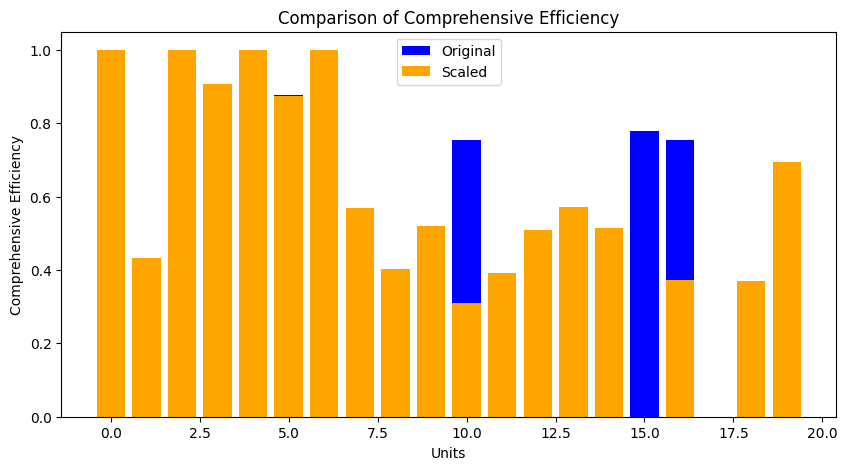

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(comprehensive_efficiency)), comprehensive_efficiency, color='blue', label='Original')
plt.bar(range(len(comprehensive_efficiency_r_con)), comprehensive_efficiency_r_con, color='orange', label='Scaled')
plt.xlabel('Units')
plt.ylabel('Comprehensive Efficiency')
plt.title('Comparison of Comprehensive Efficiency')
plt.legend()
plt.show()

In [ ]:
input_efficeincy

array([[1.        , 1.        ,        nan],
       [0.76954123, 0.76281822, 0.76950227],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [0.95470241, 0.94594304, 0.95206084],
       [1.46578638, 0.99999999, 1.        ],
       [1.        , 1.        , 1.        ],
       [0.80363367, 0.78846607, 0.48893613],
       [0.83920718, 0.86290258, 0.88691904],
       [0.59257747, 0.61393661, 0.73225645],
       [1.        , 1.        , 1.00000004],
       [1.        , 1.        , 1.00000006],
       [0.52505557, 0.56151776, 0.80216823],
       [0.53525836, 0.57643208, 0.66907295],
       [0.88443252, 0.86501166, 0.31579788],
       [1.        , 1.        , 1.00000001],
       [1.        , 1.        , 1.        ],
       [1.        ,        nan, 1.        ],
       [0.40119909, 0.44001726, 0.88740115],
       [0.79122114, 0.76037817, 0.5594476 ]])

In [ ]:
input_efficeincy_r_con

array([[1.        , 1.        , 1.        ],
       [0.63385539, 0.68502717, 0.82409094],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.99999999],
       [1.        , 1.        , 1.        ],
       [0.99999999, 0.99999999, 1.        ],
       [1.        , 1.        , 1.        ],
       [0.94721059, 0.96450695, 0.72975857],
       [0.58684899, 0.62320628, 0.92290529],
       [0.64302337, 0.6882488 , 0.86717561],
       [0.53546015, 0.59631664, 0.81865193],
       [0.71122533, 0.75776288, 0.86617307],
       [0.60150838, 0.65193672, 0.7306691 ],
       [0.56718673, 0.61929073, 0.78028535],
       [0.95131521, 0.97381944, 0.72069334],
       [1.        , 1.        , 1.        ],
       [0.70586331, 0.7671664 , 0.67163245],
       [1.        ,        nan,        nan],
       [0.36534172, 0.41764052, 0.69863873],
       [0.98767465, 0.98932503, 0.92571299]])

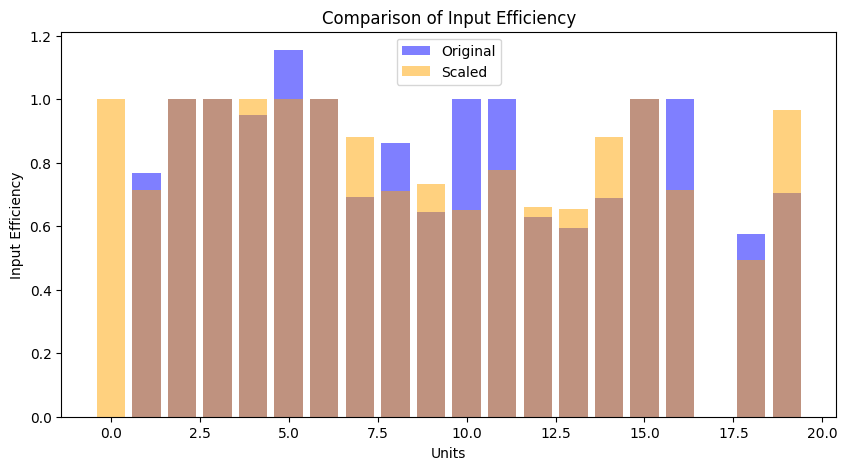

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting input efficiency values for the original data
plt.bar(np.arange(len(input_efficeincy)), input_efficeincy.mean(axis=1), color='blue', alpha=0.5, label='Original')

# Plotting input efficiency values for the scaled data
plt.bar(np.arange(len(input_efficeincy_r_con)), input_efficeincy_r_con.mean(axis=1), color='orange', alpha=0.5, label='Scaled')

plt.xlabel('Units')
plt.ylabel('Input Efficiency')
plt.title('Comparison of Input Efficiency')
plt.legend()
plt.show()

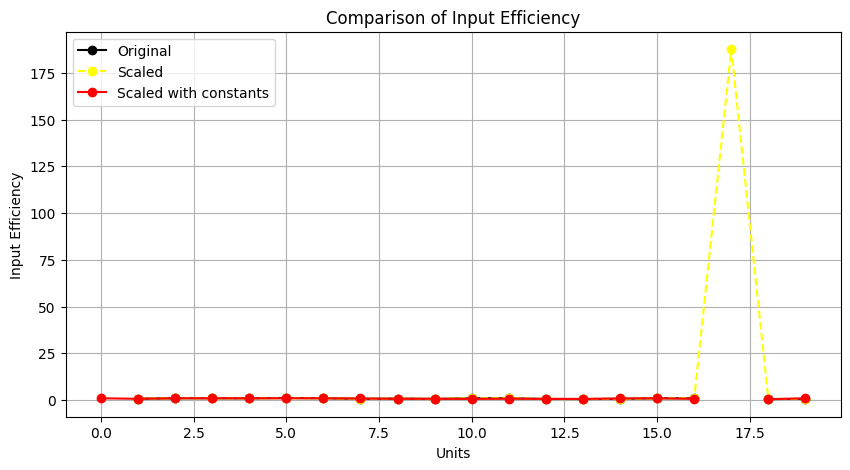

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting input efficiency values for the original data
plt.plot(np.arange(len(input_efficeincy)), input_efficeincy.mean(axis=1), marker='o', linestyle='-', color='black', label='Original')
# Plotting input efficiency values for the scaled data with constants
plt.plot(np.arange(len(input_efficeincy_r)), input_efficeincy_r.mean(axis=1), marker='o', linestyle='--', color='yellow', label='Scaled')

# Plotting input efficiency values for the scaled data with constants
plt.plot(np.arange(len(input_efficeincy_r_con)), input_efficeincy_r_con.mean(axis=1), marker='o', linestyle='-', color='red', label='Scaled with constants')

plt.xlabel('Units')
plt.ylabel('Input Efficiency')
plt.title('Comparison of Input Efficiency')
plt.legend()
plt.grid(True)
plt.show()

**r_target (Desirable Output Maximization):**

In the context of MEA, you might be interested in maximizing one specific desirable output while keeping others at their current levels or considering their interrelations.
Mathematically, r_target is the index of the specific desirable output you want to maximize. If your desirable outputs are a matrix where each row is a DMU and each column is a different type of output, then r_target is the column index of the output you are focusing on.
How to compute or set r_target depends on your specific analysis goal. If you want to improve a particular output across all DMUs, you would set r_target to the index of that output. If you want to iterate over all outputs, you could loop through all indices in your fit method.

**k_target (Undesirable Output Minimization):**

Similar to r_target, k_target is used when you're focusing on minimizing one specific undesirable output.
Mathematically, it's the index of the undesirable output you want to minimize.
The choice of k_target also depends on your analysis. If there's a specific undesirable output you want to minimize across all DMUs, you would set k_target to that output's index. For a broader analysis, you might loop over all undesirable outputs

### Defining Objective Function and Constraints

### Input Minimzation
The goal of this model is to minimize the inputs subject to the constraints of the production possibility set


\begin{align*}
\text{minimize} \quad & d_{i0} \\
\text{subject to} \quad & \sum_{j=1}^{n} \lambda_j x_{ij} \leq d_{i0}, \\
                        & \sum_{j=1}^{n} \lambda_j x_{-ij} \leq x_{i0} , \quad - i = 1, \ldots, i-1, i+1, \ldots, m \\
                        & \sum_{j=1}^{n} \lambda_j y_{rj} \geq y_{r0}, \quad r = 1, \ldots, s_1 \\
                        & \sum_{j=1}^{n} \lambda_j c_{kj} = c_{k0}, \quad k = 1, \ldots, s_2 \\
                        & \lambda_j \geq 0, \quad j = 1, \ldots, n \\
\end{align*}


Aims to find the minimum input level $ d_{i} $
that can produce at least the same amount of outputs and undesirable outputs as DMU0, using a combination of other DMUs.

In [ ]:
#d_i0_results

### Desirable Output Maximization

To find the maximum desirable output level δr that can be achieved by DMU0 without increasing the input levels and keeping the undesirable outputs constant.



\begin{align*}
\text{maximize} \quad & \delta_{r0} \\
\text{subject to} \quad & \sum_{j=1}^{n} \lambda_j y_{rj} \geq \delta_{r0}, \\
                        & \sum_{j=1}^{n} \lambda_j y_{-rj} \geq y_{-r0} , \quad - r = 1, \ldots, r-1, r+1, \ldots, s1 \\
                        & \sum_{j=1}^{n} \lambda_j x_{ij} \leq x_{i0}, \quad i = 1, \ldots, m \\
                        & \sum_{j=1}^{n} \lambda_j c_{kj} = c_{k0}, \quad k = 1, \ldots, s_2 \\
                        & \lambda_j \geq 0, \quad j = 1, \ldots, n \\
\end{align*}






In [ ]:
#delta_r0_results

### Undesirable Output Minimization:

To minimize the undesirable outputs subject to the constraints of the production possibility set.


\begin{align*}
\text{minimize} \quad & \phi_{k0} \\
\text{subject to} \quad & \sum_{j=1}^{n} \lambda_j c_{kj} = \phi_{k0} \\
                        & \sum_{j=1}^{n} \lambda_j c_{-kj} = c_{-k0}, \quad -k= 1, \ldots, k-1,
k+1, \ldots, s2\\
                        & \sum_{j=1}^{n} \lambda_j x_{ij} \leq x_{i0} , \quad  i = 1, \ldots, m \\
                        & \sum_{j=1}^{n} \lambda_j y_{rj} \geq y_{r0}, \quad r = 1, \ldots, s1 \\
                        & \lambda_j \geq 0, \quad j = 1, \ldots, n \\
\end{align*}






In [ ]:
#phi_k0_results

### Determinig the efficency of each variable of the evaluated unit

\begin{align*}
\text{maximize} \quad & \beta_{i0} + \beta_{r0} + \beta_{k0} \\
           \text{subject to} \quad & \sum_{j=1}^{n} \lambda_j x_{ij} \leq x_{i0} - \beta_{i0}(x_{i0} - d^*_{i0}), \quad i = 1, \ldots, m \\
                        & \sum_{j=1}^{n} \lambda_j y_{rj} \geq y_{r0} + \beta_{r0}(\delta^*_{r0} - y_{r0}), \quad r = 1, \ldots, s_1 \\
                        & \sum_{j=1}^{n} \lambda_j c_{kj} = c_{k0} - \beta_{k0}(c_{k0} - \phi_{k0}^*), \quad k = 1, \ldots, s_2 \\
                        & \lambda_j \geq 0, \quad j = 1, \ldots, n \\
\end{align*}


In [ ]:
#betas

### Efficiency value of each input variable

By estimating the optimal solution $(λj^*, β^*_{i0}, β^*_{r0} ,  β^*_{k0})$ of Eq. (4), the
MEA efficiency values of the evaluated unit $(x_{i0}, y_{r0}, c_{k0})$ and its individual variables can be defined.

The MEA efficiency value of each input variable is expressed by Eq.
(5):


$\Theta_i = \frac{x_{i0}- \beta^*_{i0}(x_{i0}-d^*_{i0})}{x_{i0}}$

##### Provides understanding of how efficiently each input is being utilized by each DMU relative to the ideal reference point.

In [ ]:
#input_efficeincy

### Efficiency value of desirable output variable

The MEA efficiency value of desirable output variable is expressed by Eq.
(6):


$\Theta_r = \frac{y_{r0}}{y_{r0} + \beta^*_{r0}(\delta^*_{r0}-y_{r0})}$


This code calculates and displays the MEA efficiency for the desirable output variable for each DMU based on the optimal solutions obtained from the linear programming problems. It provides insights into how effectively each DMU is converting its inputs into desirable outputs relative to the ideal reference point.

In [ ]:
##output_efficiency

### Efficiency value of undesirable output variable

The MEA efficiency value of undesirable output variable is expressed by Eq.
(8):


$\Theta_k = \frac{c_{k0}- \beta^*_{k0}(c_{k0}-\phi^*_{k0})}{c_{k0}}$

This code calculates and displays the MEA efficiency for the undesirable output variable for each DMU based on the optimal solutions obtained from the linear programming problems. It provides insights into how effectively each DMU is controlling its undesirable outputs relative to the ideal reference point

In [ ]:
#phi_k0_results

By defining the MEA efficiency values for each variable , A comprehensive efficiency containing all variables is established, as expressed by Eq. (8)

$\theta_0 = \frac{1 - \frac{1}{m} \sum_{i=1}^{m}\frac{\beta^*_{i0}(x_{i0} - d^*_{i0})}{x_{i0}}}  
{1 + \frac{1}{s_1+s_2}
\left[\sum_{r=1}^{s_1} \frac{\beta^*_{r0}(\delta^*_{r0} - y_{r0})}{y_{r0}} +
\sum_{k=1}^{s_2} \frac{\beta^*_{k0} (c_{k0} - \phi^*_{k0})}{c_{k0}}\right]}$

This code calculates and displays the comprehensive efficiency score for each DMU, providing a holistic view of the efficiency considering all variables (inputs, desirable outputs, and undesirable outputs).

In [ ]:
#comprehensive_efficiency